In [ ]:
import os
import sys
import pandas as pd
import argparse
import warnings
from utils import *
from torch import nn
import copy
from tqdm import tqdm
import random 
from data_loader import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import numpy as np
from http import HTTPStatus
import dashscope
from dashscope import Generation
import json
# import openai
from openai import OpenAI
from deepseek import DeepSeekClient
import os
from train import *
from model import GurobiPowerScheduler
from together import Together
import pickle
warnings.filterwarnings("ignore")


dashscope.api_key = 'YOUR KEY'
DEEPSEEK_API_KEY = 'YOUR KEY'
OPENAI_API_KEY = 'YOUR KEY'
LLAMA_API_KEY= 'YOUR KEY'

In [21]:
parser_train = argparse.ArgumentParser()
parser_train.add_argument('--seq_len', type=int, default=24*7)
parser_train.add_argument('--pred_len', type=int, default=24)
parser_train.add_argument('--label_len', type=int, default=0)
parser_train.add_argument('--train_length', type=int, default=17376)
parser_train.add_argument('--target', type=str, default='target')
parser_train.add_argument('--scale', type=bool, default=True)
parser_train.add_argument('--inverse', type=bool, default=True)
parser_train.add_argument('--num_epochs', type=int, default=1000)
parser_train.add_argument('--mode', type=str, default='seq2seq')
parser_train.add_argument('--quantiles', type=list, default=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95])
parser_train.add_argument('--lr', type=float, default=1e-3)
parser_train.add_argument('--patience', type=int, default=5)
parser_train.add_argument('--hidden_layers', type=list, default=[128,128,128])
parser_train.add_argument('--e2e_num_epochs', type=int, default=5)
parser_train.add_argument('--e2e_ft_lr', type=float, default=1e-6)
parser_train.add_argument('--e2e_lr', type=float, default=1e-7)#1e-7
parser_train.add_argument('--ft_lr', type=float, default=1e-4)
parser_train.add_argument('--batch_size', type=int, default=16)
parser_train.add_argument('--device', type=str, default='cuda:0' if torch.cuda.is_available() else 'cpu')
parser_train.add_argument('--epsion_p', type=float, default=1e1)
parser_train.add_argument('--epsion_l', type=float, default=1e1)
parser_train.add_argument('--metric_list', type=list, default=['pinball_loss','winkler_score_0.1','MAE','RMSE'])


parser_train.add_argument('--N_g', type=int, default=3)
parser_train.add_argument('--T', type=int, default=24)
parser_train.add_argument('--N', type=int, default=25)
parser_train.add_argument('--x_max', type=int, default=[1500,1800,2000])
parser_train.add_argument('--x_min', type=int, default=[0,0,0])
parser_train.add_argument('--z_pos_max', type=list, default=[500,700,800])
parser_train.add_argument('--z_neg_max', type=list, default=[500,700,800])
parser_train.add_argument('--z_pos_min', type=int, default=0)
parser_train.add_argument('--z_neg_min', type=int, default=0)
parser_train.add_argument('--r_neg', type=int, default=[800,800,500])
parser_train.add_argument('--r_pos', type=int, default=[800,800,500])
parser_train.add_argument('--alpha', type=list, default=[0.03 for i in range(24)]+[0.028 for i in range(24)]+[0.032 for i in range(24)])
parser_train.add_argument('--alpha_pos', type=list, default=[0.02 for i in range(24)]+[0.018 for i in range(24)]+[0.022 for i in range(24)])
parser_train.add_argument('--alpha_neg', type=list, default=[0.01 for i in range(24)]+[0.009 for i in range(24)]+[0.011 for i in range(24)])

parser_train.add_argument('--rho_z_pos', type=list, default=[0.05 for i in range(24)]+[0.045 for i in range(24)]+[0.055 for i in range(24)])
parser_train.add_argument('--rho_z_neg', type=list, default=[0.01 for i in range(24)]+[0.008 for i in range(24)]+[0.012 for i in range(24)])

parser_train.add_argument('--rho_r_pos', type=list, default=[0.1 for i in range(24)])
parser_train.add_argument('--rho_r_neg', type=list, default=[0.05 for i in range(24)])

parser_train.add_argument('--price_ratio_large', type=float, default=2.5)
parser_train.add_argument('--price_ratio_small', type=float, default=0.8)
parser_train.add_argument('--flag_dynamic_price', type=bool, default=False)
parser_train.add_argument('--flag_dynamic_mode', type=int, default=0)
parser_train.add_argument('--upper_quantiles', type=float, default=0.95)
parser_train.add_argument('--lower_quantiles', type=float, default=0.05)
parser_train.add_argument('--epsion', type=float, default=1)
parser_train.add_argument('--LLM_type', type=str, default='Qwen') #'euclidean' 'manhattan'
args = parser_train.parse_args(args=[])

In [22]:
train_load_data,train_load_loader=get_load_data(args,flag='train')
val_load_data,val_load_loader=get_load_data(args,flag='val')
test_load_data,test_load_loader=get_load_data(args,flag='test')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

(26113, 219)
(26113, 219)
(26113, 219)


In [23]:
input_size=train_load_data.X.shape[-1]
output_size=24
set_seed(42)

layer_sizes=[128,128,128]
model_load=ANN(input_size=input_size, layer_sizes=layer_sizes, output_size=output_size).to(device)
train(args, model_load, train_load_loader, val_load_loader,dir_best_model='../Model/best_ann_load.pt')

Using device: cuda:0
Epoch [1/1000] Train Loss: 0.0588 Val Loss: 0.0193
Epoch [2/1000] Train Loss: 0.0090 Val Loss: 0.0075
Epoch [3/1000] Train Loss: 0.0059 Val Loss: 0.0069


Epoch [4/1000] Train Loss: 0.0054 Val Loss: 0.0066
Epoch [5/1000] Train Loss: 0.0053 Val Loss: 0.0064
Epoch [6/1000] Train Loss: 0.0049 Val Loss: 0.0060
Epoch [7/1000] Train Loss: 0.0049 Val Loss: 0.0057
Epoch [8/1000] Train Loss: 0.0052 Val Loss: 0.0055
Epoch [9/1000] Train Loss: 0.0043 Val Loss: 0.0052
Epoch [10/1000] Train Loss: 0.0041 Val Loss: 0.0048
Epoch [11/1000] Train Loss: 0.0038 Val Loss: 0.0046
Epoch [12/1000] Train Loss: 0.0037 Val Loss: 0.0043
Epoch [13/1000] Train Loss: 0.0034 Val Loss: 0.0041
Epoch [14/1000] Train Loss: 0.0036 Val Loss: 0.0038
Epoch [15/1000] Train Loss: 0.0034 Val Loss: 0.0036
Epoch [16/1000] Train Loss: 0.0028 Val Loss: 0.0038
Epoch [17/1000] Train Loss: 0.0029 Val Loss: 0.0035
Epoch [18/1000] Train Loss: 0.0029 Val Loss: 0.0032
Epoch [19/1000] Train Loss: 0.0026 Val Loss: 0.0029
Epoch [20/1000] Train Loss: 0.0025 Val Loss: 0.0030
Epoch [21/1000] Train Loss: 0.0025 Val Loss: 0.0034
Epoch [22/1000] Train Loss: 0.0025 Val Loss: 0.0027
Epoch [23/1000] Tr

In [24]:
test_input=torch.tensor(test_load_data.X).to(device).float()
test_pred_nor=model_load(test_input).detach().cpu().numpy()
test_pred = train_load_data.inverse_transform(test_pred_nor)
test_actual_nor=test_load_data.y#.reshape(-1,1)
test_actual = train_load_data.inverse_transform(test_actual_nor)

print(MAE(test_pred,test_actual),RMSE(test_pred,test_actual),MAPE(test_pred,test_actual))

108.93030977797234 139.44284533957995 0.029723884245756324


In [25]:
val_input=torch.tensor(val_load_data.X).to(device).float()
val_pred_nor=model_load(val_input).detach().cpu().numpy()
val_pred = train_load_data.inverse_transform(val_pred_nor)
val_actual_nor=val_load_data.y#.reshape(-1,1)
val_actual = train_load_data.inverse_transform(val_actual_nor)

print(MAE(val_pred,val_actual),RMSE(val_pred,val_actual),MAPE(val_pred,val_actual))

93.48481050557758 131.1995755421263 0.027242015189285804


In [26]:
from utils import *
combined_train_data,combined_train_loader,combined_val_data,combined_val_loader,combined_test_data,combined_test_loader,combined_fine_tune_data,combined_fine_tuned_loader = obtain_price(args,train_load_data,val_load_data,test_load_data)

determinisitic_opt_layer = Determinisitic_layer(args)
intra_opt_layer = Intra_schdule_layer(args)

model_org_deterministic =  Combined_deterministic(determinisitic_opt_layer,intra_opt_layer, copy.deepcopy(model_load)).to(device)
model_org_deterministic.to(device)

Combined_deterministic(
  (model_load): ANN(
    (layers): ModuleList(
      (0): Linear(in_features=195, out_features=128, bias=True)
      (1-2): 2 x Linear(in_features=128, out_features=128, bias=True)
      (3): Linear(in_features=128, out_features=24, bias=True)
    )
  )
  (Deterministic_layer): CvxpyLayer()
  (Intra_schdule_layer): CvxpyLayer()
)

In [27]:
from E2E import E2E_test_ideal,E2E_test

In [28]:
# temp_act=torch.concatenate(actual_load_org, axis=0).detach().cpu().numpy()
# temp_for=torch.concatenate(forecasts_load_org, axis=0).detach().cpu().numpy()
# MAPE(temp_for, temp_act)

In [29]:
from E2E import E2E_test_ideal

_,_,cost_list_ideal,_,_=E2E_test_ideal(args, model_org_deterministic, combined_test_loader, train_load_data.scaler_y, time_flag=True)
_,_,cost_list_train_ideal,_,_=E2E_test_ideal(args, model_org_deterministic, combined_train_loader, train_load_data.scaler_y, time_flag=True)
_,_,cost_list_val_ideal,_,_=E2E_test_ideal(args, model_org_deterministic, combined_val_loader, train_load_data.scaler_y, time_flag=True)
solution_list_intra_org,solution_list_intra_org, cost_list_org,forecasts_load_org,actual_load_org=E2E_test(args, model_org_deterministic, combined_test_loader, train_load_data.scaler_y, time_flag=False)
solution_list_val,solution_list_val, cost_list_val,forecasts_load_val,actual_load_val=E2E_test(args, model_org_deterministic, combined_val_loader, train_load_data.scaler_y, time_flag=False)
solution_list_train,solution_list_train, cost_list_train,forecasts_load_train,actual_load_train=E2E_test(args, model_org_deterministic, combined_train_loader, train_load_data.scaler_y, time_flag=False)

_,_, cost_list_test,forecasts_load_test,actual_load_test=E2E_test(args, model_org_deterministic, combined_test_loader, train_load_data.scaler_y, time_flag=False)
_,_, cost_list_val,forecasts_load_val,actual_load_val=E2E_test(args, model_org_deterministic, combined_val_loader, train_load_data.scaler_y, time_flag=False)
_,_, cost_list_train,forecasts_load_train,actual_load_train=E2E_test(args, model_org_deterministic, combined_train_loader, train_load_data.scaler_y, time_flag=False)

--------------Load--------------
MAPE 0.026703148663574906 MAE 93.11985823148419 RMSE 124.3531393718805


Test Objective: 2392.1897411970685
--------------Load--------------
MAPE 0.023070598064098745 MAE 85.40701572073712 RMSE 102.4584223431196
Test Objective: 2650.9600324968183
--------------Load--------------
MAPE 0.028041817869858335 MAE 107.7761948995647 RMSE 130.970316216041
Test Objective: 2622.0246027563635
--------------Load--------------
MAPE 0.04184621381587809 MAE 153.14167904401464 RMSE 189.61928660631418
Test Objective: 2452.369167975787
--------------Load--------------
MAPE 0.024360145229701115 MAE 82.86548286676407 RMSE 101.95028955516986
Test Objective: 2364.880033902491
No more data to read.
--------------Load--------------
MAPE 0.03017017227816522 MAE 105.49986951062844 RMSE 140.93685249787808
Test Objective: 2329.353277041002
--------------Load--------------
MAPE 0.024123830241557388 MAE 80.48570971397567 RMSE 106.08343860868976
Test Objective: 2243.9930253559232
--------------Load--------------
MAPE 0.024338170752334676 MAE 81.1763662226925 RMSE 99.91271889690967
Test O

In [30]:
X_test=train_load_data.inverse_transform_X(test_load_data.X)
X_train=train_load_data.inverse_transform_X(train_load_data.X)
X_val=train_load_data.inverse_transform_X(val_load_data.X)

In [31]:

model_e2e_deterministic=E2E_train(args, model_org_deterministic, combined_train_loader, combined_test_loader,train_load_data.scaler_y)
_,_, cost_list_test_optnet,forecasts_load_test_optnet,actual_load_test_optnet=E2E_test(args, model_e2e_deterministic, combined_test_loader, train_load_data.scaler_y, time_flag=True)
_,_,cost_list_val_optnet,forecasts_load_val_optnet,actual_load_val_optnet=E2E_test(args, model_e2e_deterministic, combined_val_loader, train_load_data.scaler_y, time_flag=True)
_,_,cost_list_train_optnet,forecasts_load_train_optnet,actual_load_train_optnet=E2E_test(args, model_e2e_deterministic, combined_train_loader, train_load_data.scaler_y, time_flag=True)

e2e epoch: 0


e2e epoch: 1
e2e epoch: 2
torch.Size([7, 195])
--------------Load--------------
MAPE 0.02694252988914716 MAE 94.01190064714423 RMSE 124.55181906400463
Test Objective: 2711.1049990832707
torch.Size([7, 195])
--------------Load--------------
MAPE 0.020510732613577602 MAE 77.74116866556662 RMSE 95.31364092613775
Test Objective: 2950.6909936780385
torch.Size([7, 195])
--------------Load--------------
MAPE 0.030831106980249906 MAE 119.61111125802356 RMSE 145.6514126214679
Test Objective: 2922.7571717521864
torch.Size([7, 195])
--------------Load--------------
MAPE 0.04413788351336506 MAE 163.3468582583148 RMSE 201.15168399118633
Test Objective: 2870.5223173789614
torch.Size([1, 195])
--------------Load--------------
MAPE 0.030722076420563158 MAE 104.40986804043253 RMSE 120.2825094279665
Test Objective: 2580.4118367796677
No more data to read.
torch.Size([16, 195])
--------------Load--------------
MAPE 0.02893573644044121 MAE 101.48838403717188 RMSE 129.94838936805152
Test Objective: 2684.55

In [32]:
from model import *
from E2E import *

In [33]:
cost_list_test_insert=[cost_list_test[i]-cost_list_ideal[i] for i in range(len(cost_list_test))]
actual_load_test_insert=[train_load_data.scaler_y.transform(tensor.detach().cpu().numpy().reshape(1,-1)).tolist()[0] for tensor in actual_load_test]
forecasts_load_test_insert=[train_load_data.scaler_y.transform(tensor.detach().cpu().numpy().reshape(1,-1)).tolist()[0] for tensor in forecasts_load_test]

cost_list_test_insert_optnet=[cost_list_test_optnet[i]-cost_list_ideal[i] for i in range(len(cost_list_test_optnet))]
actual_load_test_insert_optnet=[train_load_data.scaler_y.transform(tensor.detach().cpu().numpy().reshape(1,-1)).tolist()[0] for tensor in actual_load_test_optnet ]
forecasts_load_test_insert_optnet=[train_load_data.scaler_y.transform(tensor.detach().cpu().numpy().reshape(1,-1)).tolist()[0] for tensor in forecasts_load_test_optnet]

cost_list_train_insert=[cost_list_train[i]-cost_list_train_ideal[i] for i in range(len(cost_list_train))]
actual_load_train_insert=[train_load_data.scaler_y.transform(tensor.detach().cpu().numpy().reshape(1,-1)).tolist()[0] for tensor in actual_load_train]
forecasts_load_train_insert=[train_load_data.scaler_y.transform(tensor.detach().cpu().numpy().reshape(1,-1)).tolist()[0] for tensor in forecasts_load_train]

cost_list_train_insert_optnet=[cost_list_train_optnet[i]-cost_list_train_ideal[i] for i in range(len(cost_list_train_optnet))]
actual_load_train_insert_optnet=[train_load_data.scaler_y.transform(tensor.detach().cpu().numpy().reshape(1,-1)).tolist()[0] for tensor in actual_load_train_optnet]
forecasts_load_train_insert_optnet=[train_load_data.scaler_y.transform(tensor.detach().cpu().numpy().reshape(1,-1)).tolist()[0] for tensor in forecasts_load_train_optnet]

cost_list_val_insert=[cost_list_val[i]-cost_list_val_ideal[i] for i in range(len(cost_list_val))]
actual_load_val_insert=[train_load_data.scaler_y.transform(tensor.detach().cpu().numpy().reshape(1,-1)).tolist()[0] for tensor in actual_load_val]
forecasts_load_val_insert=[train_load_data.scaler_y.transform(tensor.detach().cpu().numpy().reshape(1,-1)).tolist()[0] for tensor in forecasts_load_val]    

cost_list_val_insert_optnet=[cost_list_val_optnet[i]-cost_list_val_ideal[i] for i in range(len(cost_list_val_optnet))]
actual_load_val_insert_optnet=[train_load_data.scaler_y.transform(tensor.detach().cpu().numpy().reshape(1,-1)).tolist()[0] for tensor in actual_load_val_optnet ]
forecasts_load_val_insert_optnet=[train_load_data.scaler_y.transform(tensor.detach().cpu().numpy().reshape(1,-1)).tolist()[0] for tensor in forecasts_load_val_optnet]


db_train = CurveDictDB()
cur_id_start = max(db_train.data.keys(), default=0) + 1
for i, (cost, load, fine_tuned_load, actual_load) in enumerate(zip(cost_list_train_insert, forecasts_load_train_insert,forecasts_load_train_insert_optnet, actual_load_train_insert)):
    record = {
        'id': cur_id_start + i,
        'flag': 0,
        'prompt': '',
        'load': load,
        'fine_tuned_load': fine_tuned_load,
        'cost': cost,
        'actual_load': actual_load,
        'cost_reduction': 0, # 1代表成本比fine tune前低
    }
    db_train.insert(record)

db_val = CurveDictDB()
cur_id_start_val = max(db_val.data.keys(), default=0) + 1
for i, (cost, load, fine_tuned_load, actual_load) in enumerate(zip(cost_list_val_insert, forecasts_load_val_insert, forecasts_load_val_insert_optnet, actual_load_val_insert)):
    record = {
        'id': cur_id_start_val + i,
        'flag': 0,
        'prompt': '',
        'load': load,
        'fine_tuned_load': fine_tuned_load,
        'cost': cost,
        'actual_load': actual_load,
        'cost_reduction': 0,
    }
    db_val.insert(record)


In [34]:
def generate_prompt_sys(args,data):
    # Return English prompt
    prompt = (
        f"You are a power dispatch expert. There are {args.N_g} generating units:\n"
        f"Unit 1: {args.x_min}~{args.x_max} MW, "
        f"Unit 2: {args.x_min}~{args.x_max} MW, "
        f"Unit 3: {args.x_min}~{args.x_max} MW.\n"
        f"Unit 1 generation cost: {args.alpha[0:args.T]}*x RMB/kWh, "
        f"Unit 2 generation cost: {args.alpha[args.T:2*args.T]}*x RMB/kWh, "
        f"Unit 3 generation cost: {args.alpha[args.T*2:args.T*3]}*x RMB/kWh.\n"
        f"Unit 1 positive reserve limit: {args.rho_z_pos[0:args.T]} RMB/kWh, "
        f"Unit 1 negative reserve limit: {args.rho_z_neg[0:args.T]} RMB/kWh.\n"
        f"Unit 2 positive reserve limit: {args.rho_z_pos[args.T:2*args.T]} RMB/kWh, "
        f"Unit 2 negative reserve limit: {args.rho_z_neg[args.T:2*args.T]} RMB/kWh.\n"
        f"Unit 3 positive reserve limit: {args.rho_z_pos[args.T*2:args.T*3]} RMB/kWh, "
        f"Unit 3 negative reserve limit: {args.rho_z_neg[args.T*2:args.T*3]} RMB/kWh.\n"   
    )
    
    return prompt




In [35]:
data_iter = iter(combined_test_loader)
input_load_test, labels_load_test, alpha_test, alpha_z_test, rho_z_test, rho_r_test = next(data_iter)

alpha_sample=alpha_test[0,:].detach().cpu().numpy()
alpha_z_sample=alpha_z_test[0,:].detach().cpu().numpy()
rho_z_sample=rho_z_test[0,:].detach().cpu().numpy()
rho_r_sample=rho_r_test[0,:].detach().cpu().numpy()

alpha_sample_torch=torch.tensor(alpha_sample).unsqueeze(0).to(device)#.float()
alpha_z_sample_torch=torch.tensor(alpha_z_sample).unsqueeze(0).to(device)#.float()
rho_z_sample_torch=torch.tensor(rho_z_sample).unsqueeze(0).to(device)#.float()
rho_r_sample_torch=torch.tensor(rho_r_sample).unsqueeze(0).to(device)#.float()

optimization_module = GurobiPowerScheduler(args, alpha_sample, alpha_z_sample, rho_z_sample, rho_r_sample)

x_max_list (72,)
r_pos_list (69,)
r_neg_list (69,)
[1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500.
 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500.
 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800.
 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.]


In [36]:
def few_shot_prompt_generate(args, similar_days, max_strategies=10, max_attempts=5,failure_strategy=None):  
    """  
    Generate few-shot prompts for small-scale adjustment strategies  
    Each adjustment modifies no more than 5 time points, gradually building a strategy library  
      
    Parameters:  
        args: Model parameters  
        db: Database connection object  
        similar_days: List of similar day data  
        max_strategies: Maximum number of valid strategies  
        max_attempts: Maximum number of attempts  
          
    Returns:  
        tuple: (Strategy history string, List of valid strategies)  
    """  
    # Get average load of similar days
    similar_day_load_nor = np.mean([day['load'] for day in similar_days], axis=0)  
    similar_day_actual_nor = np.mean([day['actual_load'] for day in similar_days], axis=0)  
      
    # Calculate original cost  
    similar_day_load_numpy = train_load_data.scaler_y.inverse_transform(np.array(similar_day_load_nor).reshape(1,-1))[0]  
    similar_day_actual_load_numpy = train_load_data.scaler_y.inverse_transform(np.array(similar_day_actual_nor).reshape(1,-1))[0]  
    _, _, original_cost = optimization_module.forward(similar_day_load_numpy, similar_day_actual_load_numpy)  
    original_cost = original_cost.item()  
      
    # Strategy generation prompt template  
    sim_data = {"load": similar_day_load_nor}  
    system_prompt = generate_prompt_sys(args, sim_data)  
    higher_flag = "higher" if sum(np.array(similar_day_load_nor) - np.array(similar_day_actual_nor)) > 0 else "lower"  
    reduce_flag = "reduce" if higher_flag == "higher" else "increase"  
    system_prompt += f"""\n The maximum load occurs at {int(np.argmax(similar_day_load_nor))} hour, and the minimum load occurs at {int(np.argmin(similar_day_load_nor))} hour.\n\n"""  
    system_prompt += f"""  
    You have two approaches to reduce cost:  

    1. Compare the actual value and forecast of the similar day, try to learn some error reduction strategies. In this case, the similar day forecast is {higher_flag} than actual, so you can try to {reduce_flag} the load in some hours to reduce cost.  
    2. Compare the future positive and negative reserve prices.  
    - If the positive reserve price is much higher than the negative reserve price, you should schedule more generation in the day-ahead market.  
    - If the negative reserve price is higher, schedule less generation to reduce potential costs.  
    """  

    if failure_strategy==None:
        pass
    else:
        system_prompt+='Here is failed strategy:\n'+failure_strategy

    output_require_prompt = f"""  
    You are an expert in electricity load curve optimization. Your task is to generate Python functions that implement small-scale optimization strategies for daily electricity load curves.  

    Requirements:  
    1. Generate exactly 10 distinct Python functions named "strategy_1", "strategy_2", "strategy_3", "strategy_4", "strategy_5", "strategy_6", "strategy_7", "strategy_8", "strategy_9", and "strategy_10".  
    2. The strategy should focus on a *different* part of the load curve, avoiding concentrating all changes in same time intervals.  
    2. Each function must:  
       - Take a single argument: the original load curve (list of 24 hourly values)  
       - Return a list of 24 numbers (deltas) representing adjustments to each hour  
    3. Each strategy must:  
       - Adjust no more than 5 time points (hours)  
       - Target adjacent hours (e.g., 7pm to 9pm)  
       - Keep adjustments within ±5% of the original value at each hour  
    4. Use only basic Python operations (no external libraries)  
    5. Include comments explaining:  
       - Which specific hours are targeted  
       - Why this strategy might reduce electricity costs  
    6. Example strategies:  

    Example 1: Reduce evening peak  
    def strategy_1(original_load):  
        # Focus: Reduce peak at 18:00 and 19:00 only  
        deltas = [0] * 24  
        # Only adjust hours 18 and 19  
        deltas[18] = -original_load[18] * 0.02  # Reduce by 2%  
        deltas[19] = -original_load[19] * 0.02  # Reduce by 2%  
        return deltas  

    Example 2: Shift load from afternoon to late afternoon  
    def strategy_2(original_load):  
        # Focus: Shift load from 14:00 to 15:00  
        deltas = [0] * 24  
        # Only adjust hours 14 and 15  
        deltas[14] = original_load[14] * 0.015  # Reduce at 14:00  
        deltas[15] = original_load[14] * 0.015   # Increase at 15:00  
        return deltas  

    Example 3: Increase off-peak consumption  
    def strategy_3(original_load):  
        # Focus: Slightly increase off-peak at 2:00 and 3:00  
        deltas = [0] * 24  
        # Only adjust hours 2 and 3  
        deltas[2] = original_load[2] * 0.03  # Increase by 3%  
        deltas[3] = original_load[3] * 0.03  # Increase by 3%  
        return deltas  

    Example 4: Flatten morning peak  
    def strategy_4(original_load):  
        # Focus: Reduce morning peak at 8:00 and shift to 9:00  
        deltas = [0] * 24  
        # Only adjust hours 8 and 9  
        deltas[8] = -original_load[8] * 0.05  # Reduce at 8:00  
        deltas[9] = original_load[8] * 0.05   # Increase at 9:00  
        return deltas  

    Example 5: Smooth transition between peak and off-peak  
    def strategy_5(original_load):  
        # Focus: Smooth transition from evening to night (20:00-21:00)  
        deltas = [0] * 24  
        # Only adjust hours 20 and 21  
        deltas[20] = -original_load[20] * 0.02  # Reduce at 20:00  
        deltas[21] = -original_load[20] * 0.02   # Increase at 21:00  
        return deltas  

    Now generate 5 distinct strategies for the current load curve optimization task.  
    """  
      
    # Store valid strategies  
    valid_strategies = []  
    strategy_history = ""  
    attempt_count = 0  
    full_prompt = ''  
    while len(valid_strategies) < max_strategies and attempt_count < max_attempts:  
        attempt_count += 1  
        print(f"Strategy generation attempt #{attempt_count} (Current valid strategies: {len(valid_strategies)}/{max_strategies})")  
        if valid_strategies != []:  
            history_snippet = 'Here are some previously discovered effective small-scale adjustment strategies:\n, you are modified based on these strategies or regenerate new strategies.\n'  
            for i in range(len(valid_strategies)):  
                history_snippet += (f"Strategy {i+1}:\n{valid_strategies[i]['code']}\n\n")  
        else:  
            history_snippet = "No previously discovered effective small-scale adjustment strategies."  
        if attempt_count >= int(max_attempts)/2:  
            print('Providing actual load values')  
            full_prompt += (f"SYSTEM INSTRUCTIONS:\n{system_prompt}\n\n"  
                            f"HISTORICAL CONTEXT:\n{history_snippet}\n\n"  
                            f"This is your FINAL attempt for this similar day. The actual load is {similar_day_actual_nor}. Use all your knowledge and experience to produce the best possible optimized load curves.\n\n"  
                            f"TASK REQUIREMENTS:\n{output_require_prompt}\n\n")  
        else:  
            full_prompt += (  
                            f"SYSTEM INSTRUCTIONS:\n{system_prompt}\n\n"  
                            f"HISTORICAL CONTEXT:\n{history_snippet}\n\n"  
                            f"TASK REQUIREMENTS:\n{output_require_prompt}\n\n")  
        try:  
            if args.LLM_type == 'Qwen':  
                response = Generation.call(  
                    model="qwen-plus",  
                    messages=[  
                        {"role": "system", "content": full_prompt},  
                    ],  
                    parameters={  
                        "temperature": 0.5,  
                        "max_tokens": 1024,  
                        "top_k": 20  
                    }  
                )  
                raw_text = response.output.text.strip()  
                func_code = extract_pure_code(raw_text)  
                  

            elif args.LLM_type == 'Deepseek':  
                client = OpenAI(api_key=DEEPSEEK_API_KEY,  
                base_url="https://api.deepseek.com")  
                response = client.chat.completions.create(  
                    model="deepseek-chat",  
                    messages=[  
                        {"role": "system", "content": full_prompt},  
                    ],  
                    temperature=0.5,  
                    max_tokens=2048,  
                    stream=False,  
                )  
                raw_text = response.choices[0].message.content.strip()  
                func_code = extract_pure_code(raw_text)  
   
            elif args.LLM_type == 'Llama':  
                client = Together(api_key=LLAMA_API_KEY)  
                response = client.chat.completions.create(  
                    model="meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",  
                    messages=[  
                    {"role": "system", "content": full_prompt},  
                ],  
                temperature=1,  
                max_tokens=2048,  
                stream=False,  
                top_k=20,  
                )  
                raw_text = response.choices[0].message.content.strip()  
                func_code = extract_pure_code(raw_text)  
  
            # Evaluate all strategy functions (separately)  
            strategy_results = evaluate_individual_strategies(  
                func_code,   
                similar_day_load_nor.tolist(),  
                max_change_percent=0.1  
            )  
              
            if not strategy_results:  
                print("No valid strategy functions generated")  
                continue  
                  
            for name, strategy in strategy_results.items():  
                try:  
                    adjusted_curve = strategy['adjusted_curve']  
                    adjusted_numpy =  train_load_data.scaler_y.inverse_transform(np.array(adjusted_curve).reshape(1,-1))[0]  
                      
                    _, _, strategy_cost = optimization_module.forward(adjusted_numpy, similar_day_actual_load_numpy)  
                    strategy_cost = strategy_cost.item()  
                      
                    if strategy_cost < original_cost - 1:  
                        adjusted_hours = sum(1 for delta in strategy['delta_curve'] if abs(delta) > 1e-5)  
                        if adjusted_hours <= 5:  
                            valid_strategies.append({  
                                'name': 'Strategy ' + str(len(valid_strategies)+1),  
                                'code': strategy['func_code'],  
                                'cost_reduction': original_cost - strategy_cost,  
                                'final_cost': strategy_cost,  
                                'original_cost': original_cost,  
                                'original_load' : similar_day_load_nor.tolist(),  
                                'actual_load': similar_day_actual_nor.tolist(),  
                                'adjusted_curve': adjusted_curve,  
                                'adjusted_hours': adjusted_hours  
                            })  
                              
                            strategy_history += (  
                                f"Strategy {name} reduced cost on similar day: {original_cost - strategy_cost:.2f}\n"  
                                f"Adjusted time points: {adjusted_hours} hours\n"  
                                f"Code:\n{strategy['func_code']}\n\n"  
                            )  
                              
                            print(f"Discovered valid strategy {name}, cost {strategy_cost:.2f}, original cost {original_cost:.2f}, (reduction {original_cost - strategy_cost:.2f})")  
                              
                            if len(valid_strategies) >= max_strategies:  
                                break  
                except Exception as e:  
                    print(f"Error evaluating strategy {name}: {str(e)}")  
          
        except Exception as e:  
            print(f"Strategy generation exception: {str(e)}")  
      
    if not valid_strategies:  
        strategy_history = "No valid small-scale adjustment strategies found"  
      
    return strategy_history, valid_strategies

In [ ]:

output_require_prompt = """Please learn from the few-shot record and derived a combined strategy to adjust the original load curve.
    You can only change several time points, and each point can only be changed within ±10% of the original value.
    Output a Python function named "adjustment_strategy" that implements the optimization strategy. The function should take the original load curve as input and return a list of 24 delta values (changes to apply).

    Requirements:
    1. Define a function: def adjustment_strategy(original_load: list) -> list:
    2. The function must return a list of 24 numbers (deltas)
    3. Use only basic Python operations (no external libraries)
    4. Include comments explaining your strategy
    5. Example (It is just an example, do not copy it directly):
        def adjustment_strategy(original_load):
            deltas = []
            for i, load_val in enumerate(original_load):
                if 8 <= i < 18:
                    deltas.append(load_val * 0.05) 
                if 20 <= i <22:
                    deltas.append(-load_val * 0.03) 
            return deltas
    """

### main

Processing inquiry 1/29
Similar days original cost: 2435.5803364618123 Similar days optnet cost: 2449.5214948150015
Found 3 similar days for inquiry 0
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_4, cost 2431.55, original cost 2435.58, (reduction 4.03)
Strategy generation attempt #2 (Current valid strategies: 1/20)
Discovered valid strategy strategy_4, cost 2431.55, original cost 2435.58, (reduction 4.03)
Strategy generation attempt #3 (Current valid strategies: 2/20)
Providing actual load values
Discovered valid strategy strategy_4, cost 2431.50, original cost 2435.58, (reduction 4.08)
Discovered valid strategy strategy_6, cost 2431.86, original cost 2435.58, (reduction 3.72)
Strategy generation attempt #4 (Current valid strategies: 4/20)
Providing actual load values
Discovered valid strategy strategy_4, cost 2431.50, original cost 2435.58, (reduction 4.08)
Discovered valid strat

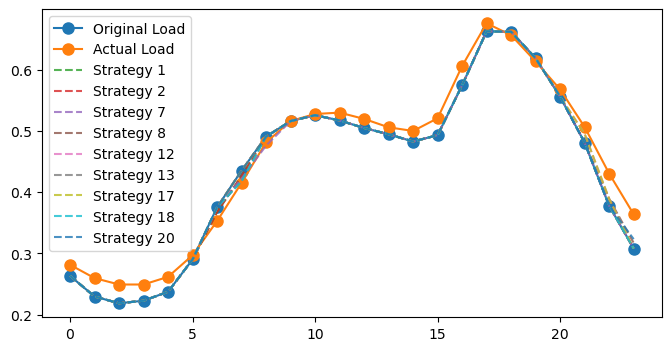

Found 0 relevant failed reflection cases for inquiry 0


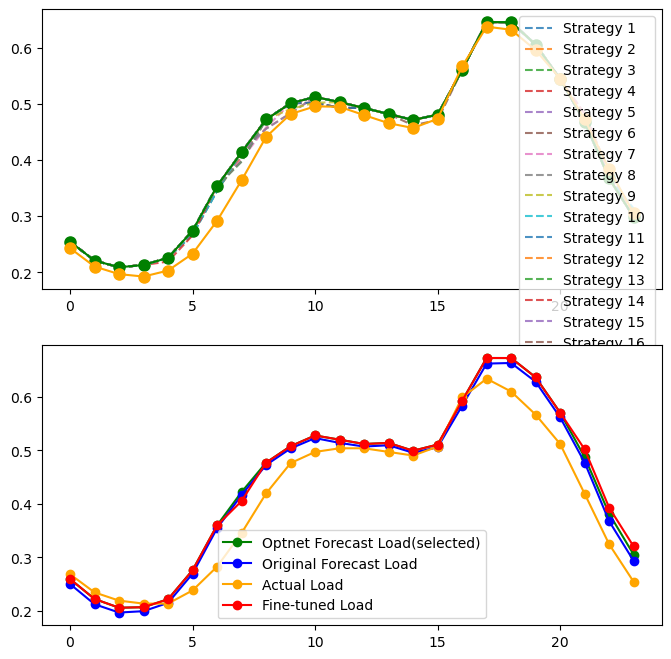

Original cost: 2542.2191690191626, Optnet cost: 2544.5700436720253, Fine-tuned cost: 2550.909637021673
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_1, cost 2533.39, original cost 2542.22, (reduction 8.82)
Discovered valid strategy strategy_2, cost 2538.00, original cost 2542.22, (reduction 4.22)
Discovered valid strategy strategy_7, cost 2539.46, original cost 2542.22, (reduction 2.76)
Discovered valid strategy strategy_9, cost 2537.67, original cost 2542.22, (reduction 4.55)
Strategy generation attempt #2 (Current valid strategies: 4/5)
Providing actual load values
Discovered valid strategy strategy_1, cost 2533.39, original cost 2542.22, (reduction 8.82)
The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 2/29
Similar days original

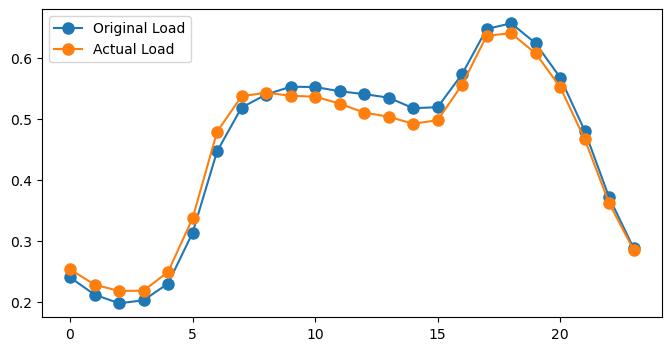

Inquiry 1: No valid strategy found, using original curve as fine-tuned result.
2553.103559707567
2544.507586366847
2547.677383041671


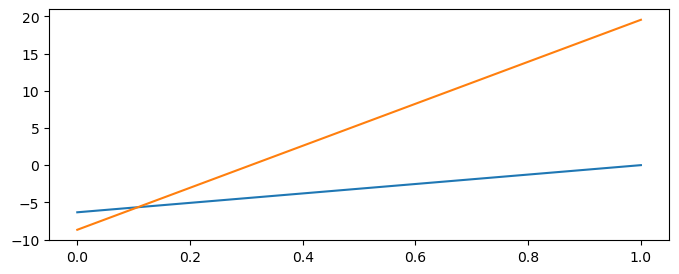

Processing inquiry 3/29
Similar days original cost: 2570.8920236602726 Similar days optnet cost: 2581.6658456427954
Found 3 similar days for inquiry 2
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_2, cost 2569.52, original cost 2570.89, (reduction 1.37)
Strategy generation attempt #2 (Current valid strategies: 1/20)
Discovered valid strategy strategy_1, cost 2565.99, original cost 2570.89, (reduction 4.90)
Discovered valid strategy strategy_2, cost 2569.52, original cost 2570.89, (reduction 1.37)
Discovered valid strategy strategy_6, cost 2566.04, original cost 2570.89, (reduction 4.85)
Discovered valid strategy strategy_8, cost 2568.87, original cost 2570.89, (reduction 2.02)
Strategy generation attempt #3 (Current valid strategies: 5/20)
Providing actual load values
Discovered valid strategy strategy_1, cost 2565.99, original cost 2570.89, (reduction 4.90)
Discovered valid strate

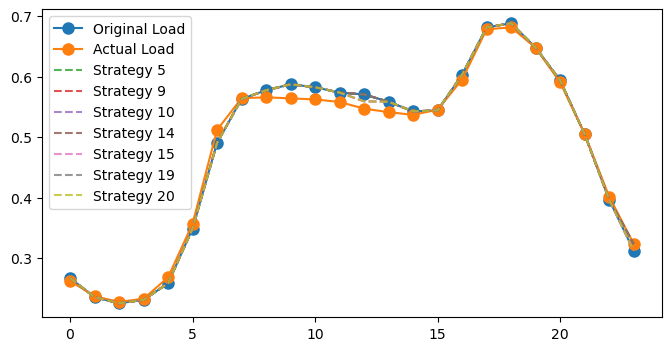

Found 1 relevant failed reflection cases for inquiry 2


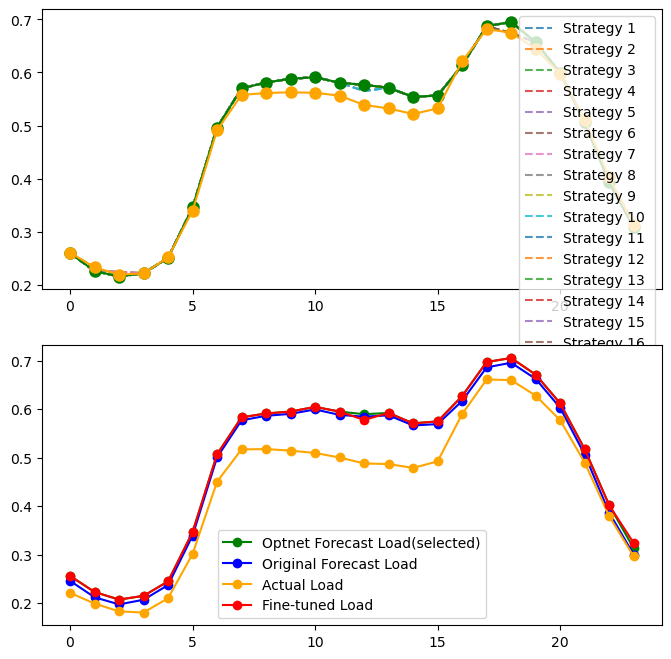

Original cost: 2671.7846971765457, Optnet cost: 2723.330770526856, Fine-tuned cost: 2723.03598391512
2592.6639388638932
2604.1153144201835
2606.130249999487


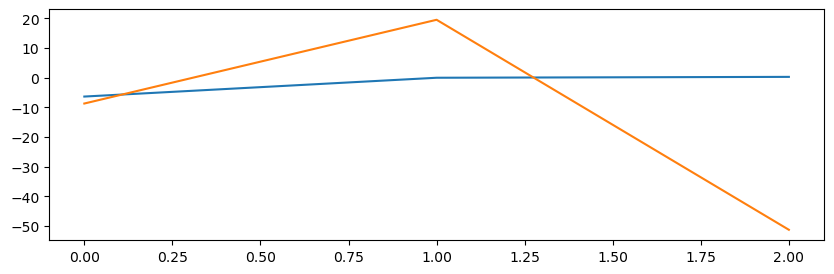

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [1]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 4/29
Similar days original cost: 2573.2899296729074 Similar days optnet cost: 2539.530576103658
Found 3 similar days for inquiry 3
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2567.88, original cost 2573.29, (reduction 5.41)
Discovered valid strategy strategy_4, cost 2571.71, original cost 2573.29, (reduction 1.58)
Discovered valid strategy strategy_9, cost 2558.17, original cost 2573.29, (reduction 15.12)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_1, cost 2567.88, original cost 2573.29, (reduction 5.41)
Discovered valid strategy strategy_4, cost 2571.71, original c

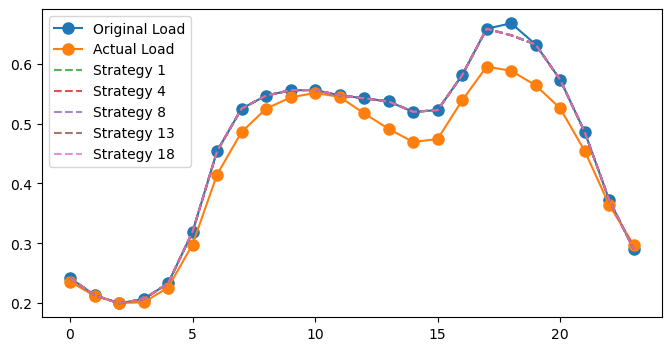

Found 1 relevant failed reflection cases for inquiry 3


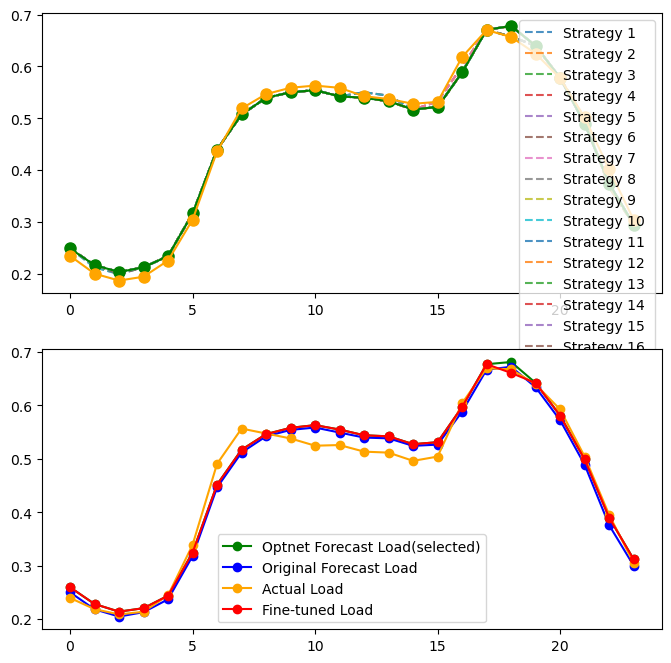

Original cost: 2629.538245284587, Optnet cost: 2590.3918243956864, Fine-tuned cost: 2591.617892176455
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_2, cost 2628.18, original cost 2629.54, (reduction 1.36)
Discovered valid strategy strategy_6, cost 2628.29, original cost 2629.54, (reduction 1.25)
Discovered valid strategy strategy_9, cost 2617.66, original cost 2629.54, (reduction 11.88)
Strategy generation attempt #2 (Current valid strategies: 3/5)
Providing actual load values
Discovered valid strategy strategy_2, cost 2628.18, original cost 2629.54, (reduction 1.36)
Discovered valid strategy strategy_4, cost 2628.29, original cost 2629.54, (reduction 1.25)
2601.8825154690667
2600.6844419140593
2602.502160543729


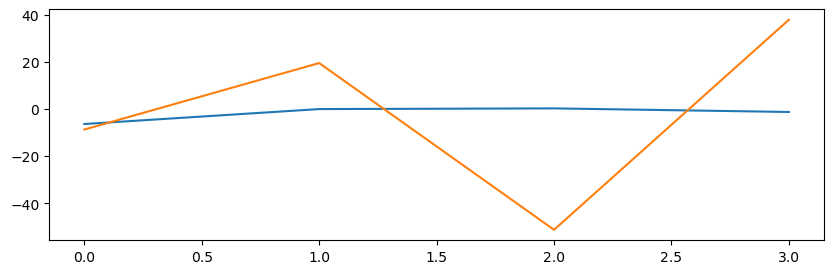

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [1]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 5/29
Similar days original cost: 2600.1650247490898 Similar days optnet cost: 2552.5116554998654
Found 3 similar days for inquiry 4
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_9, cost 2594.83, original cost 2600.17, (reduction 5.34)
Strategy generation attempt #2 (Current valid strategies: 1/20)
Discovered valid strategy strategy_6, cost 2584.61, original cost 2600.17, (reduction 15.56)
Discovered valid strategy strategy_9, cost 2594.83, original cost 2600.17, (reduction 5.34)
Strategy generation attempt #3 (Current valid strategies: 3/20)
Providing actual load values
Discovered valid strategy strategy_6, cost 2578.62, original

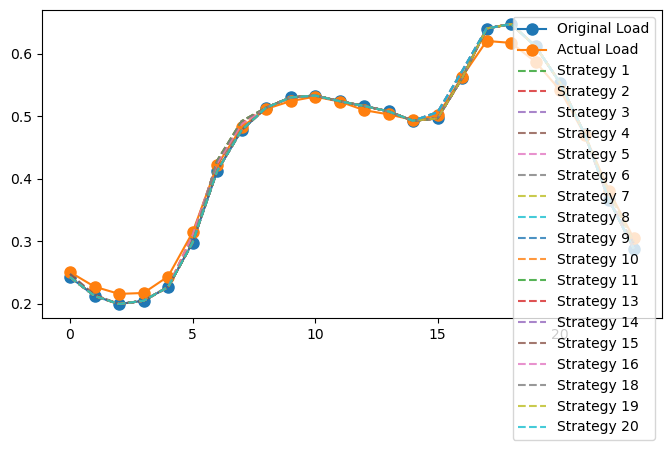

Found 1 relevant failed reflection cases for inquiry 4


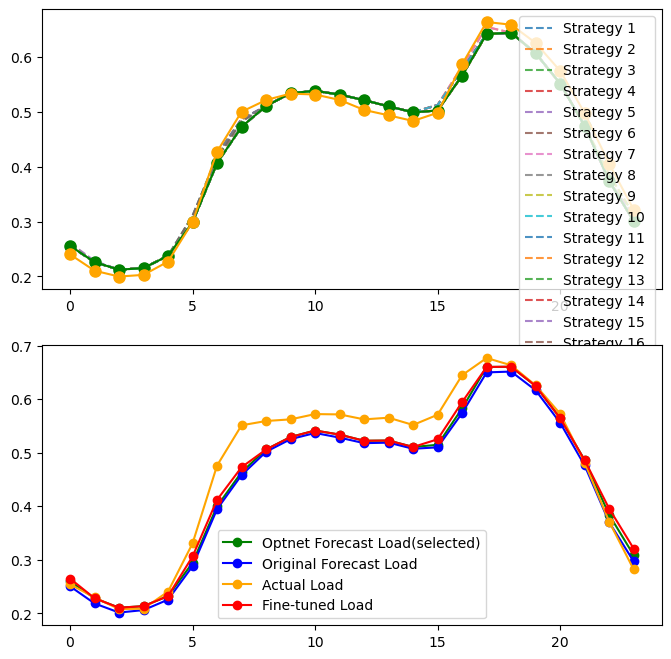

Original cost: 3007.3149539273973, Optnet cost: 2923.678105981946, Fine-tuned cost: 2892.185523003572
2682.969003160733
2665.283174727637
2660.438833035698


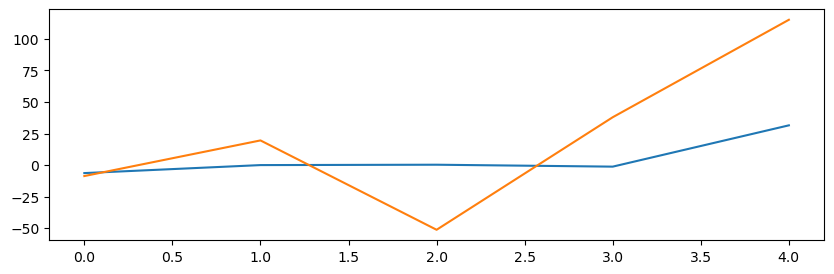

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [1]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 6/29
Similar days original cost: 2387.10352160342 Similar days optnet cost: 2424.3514759806544
Found 3 similar days for inquiry 5
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2382.58, original cost 2387.10, (reduction 4.53)
Strategy generation attempt #2 (Current valid strategies: 1/20)
Discovered valid strategy strategy_1, cost 2382.58, original cost 2387.10, (reduction 4.53)
Discovered valid strategy strategy_4, cost 2380.91, original cost 2387.10, (reduction 6.20)
Discovered valid strategy strategy_6, cost 2384.03, original cost 2387.10, (reduction 3.08)
Discovered valid strategy strategy_8, cost 2382.00, original cos

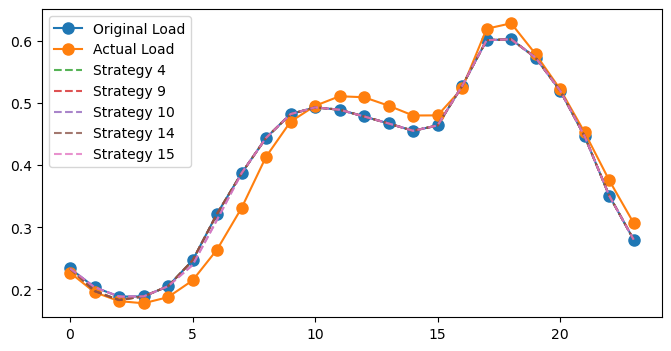

Found 1 relevant failed reflection cases for inquiry 5


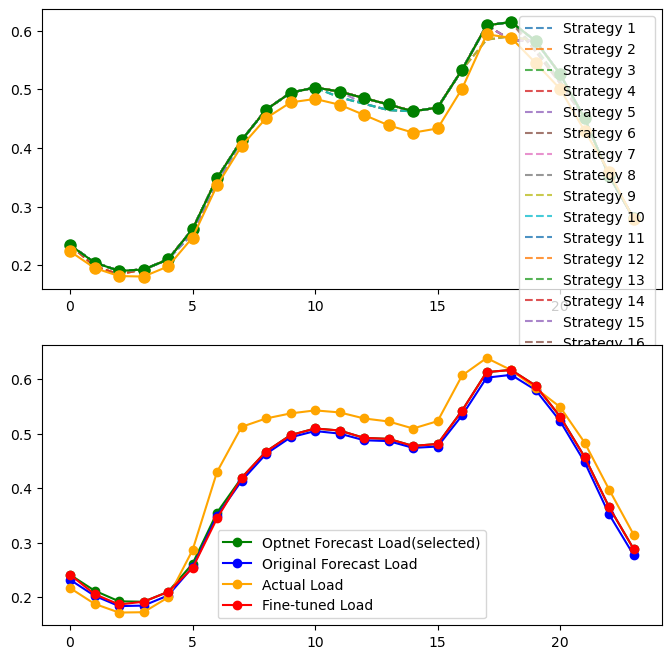

Original cost: 2980.8730139972267, Optnet cost: 2903.0256438441575, Fine-tuned cost: 2913.081424588591
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_7, cost 2960.20, original cost 2980.87, (reduction 20.67)
Strategy generation attempt #2 (Current valid strategies: 1/5)
Providing actual load values
Discovered valid strategy strategy_2, cost 2977.00, original cost 2980.87, (reduction 3.88)
Discovered valid strategy strategy_7, cost 2959.91, original cost 2980.87, (reduction 20.97)
Strategy generation attempt #3 (Current valid strategies: 3/5)
Providing actual load values
Discovered valid strategy strategy_2, cost 2977.00, original cost 2980.87, (reduction 3.88)
Discovered valid strategy strategy_3, cost 2959.91, original cost 2980.87, (reduction 20.97)
2732.6196716334816
2704.90691958039
2702.5459316278466


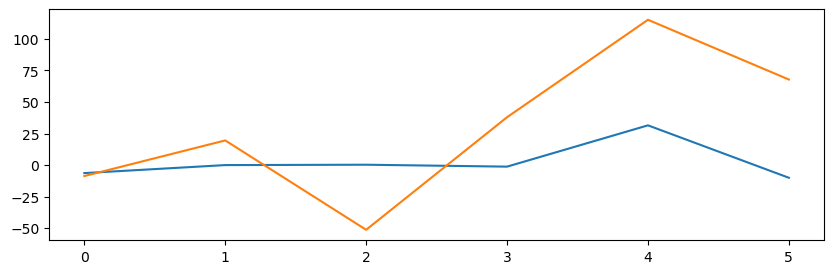

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [1]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 7/29
Similar days original cost: 2409.8484177398886 Similar days optnet cost: 2418.1397237641813
Found 3 similar days for inquiry 6
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_4, cost 2408.08, original cost 2409.85, (reduction 1.77)
Discovered valid strategy strategy_6, cost 2404.41, original cost 2409.85, (reduction 5.43)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Discovered valid strategy strategy_5, cost 2405.26, original cost 2409.85, (reduction 4.59)
Strategy generation attempt #3 (Current valid strategies: 3/20)
Providing actual load values
Strategy generation attempt #4 (Current valid strategies: 3/2

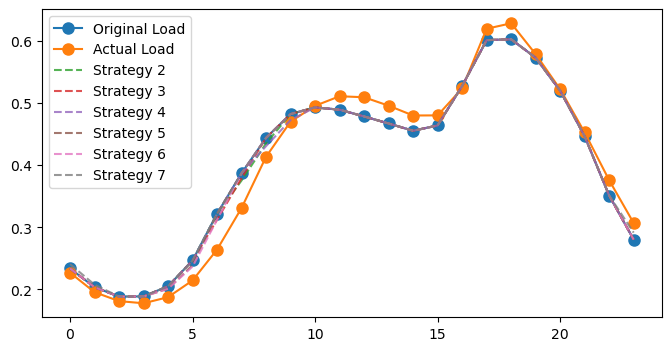

Found 1 relevant failed reflection cases for inquiry 6


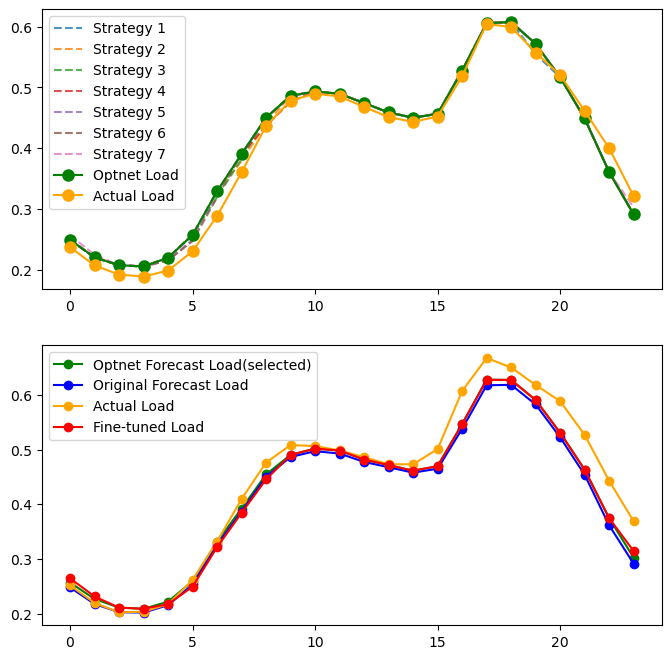

Original cost: 2838.6203544892073, Optnet cost: 2748.293281190515, Fine-tuned cost: 2768.2319544425427
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_4, cost 2826.59, original cost 2838.62, (reduction 12.03)
Discovered valid strategy strategy_7, cost 2822.57, original cost 2838.62, (reduction 16.05)
Strategy generation attempt #2 (Current valid strategies: 2/5)
Providing actual load values
Discovered valid strategy strategy_4, cost 2826.59, original cost 2838.62, (reduction 12.03)
Discovered valid strategy strategy_6, cost 2822.57, original cost 2838.62, (reduction 16.05)
Discovered valid strategy strategy_8, cost 2829.79, original cost 2838.62, (reduction 8.83)
2747.762626327157
2711.1049712389795
2711.929649172803


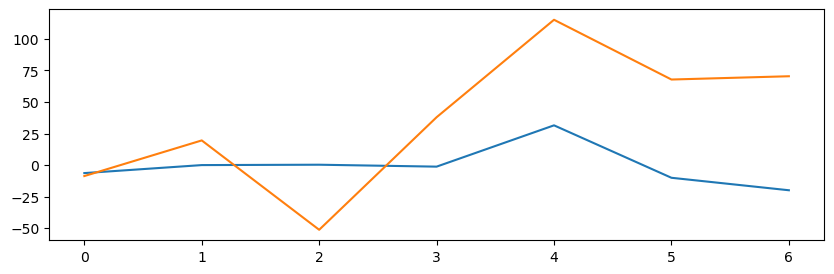

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [1]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 8/29
Similar days original cost: 2580.3073414390783 Similar days optnet cost: 2548.5697874565226
Found 3 similar days for inquiry 7
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_2, cost 2576.45, original cost 2580.31, (reduction 3.86)
Discovered valid strategy strategy_8, cost 2572.00, original cost 2580.31, (reduction 8.30)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Discovered valid strategy strategy_2, cost 2576.45, original cost 2580.31, (reduction 3.86)
Discovered valid strategy strategy_4, cost 2572.00, original cost 2580.31, (reduction 8.30)
Discovered valid strategy strategy_7, cost 2573.38, original c

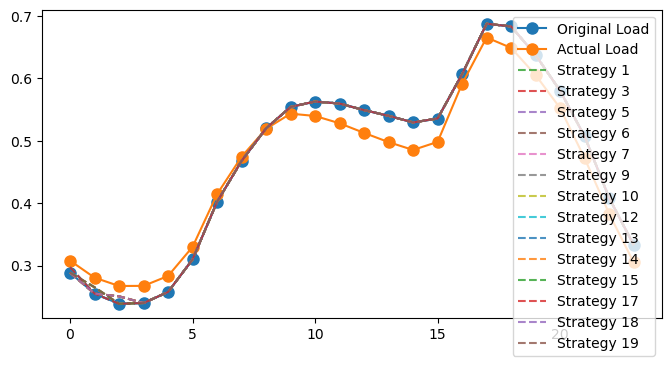

Found 1 relevant failed reflection cases for inquiry 7


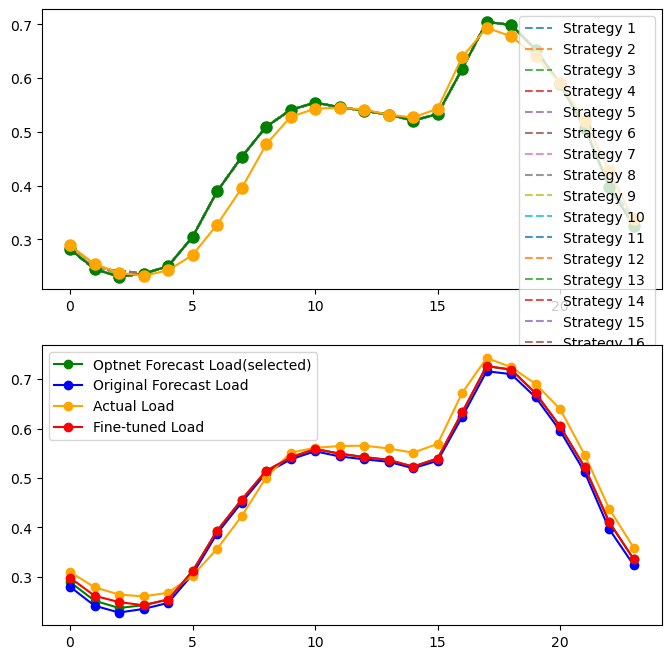

Original cost: 2928.452487846911, Optnet cost: 2823.607498575926, Fine-tuned cost: 2801.7661898058795
2770.348859017126
2725.167787156098
2723.159216751938


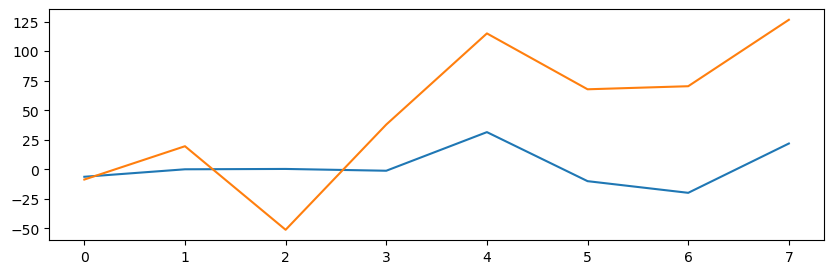

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [1]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 9/29
Similar days original cost: 2720.589481968145 Similar days optnet cost: 2773.461922691524
Found 3 similar days for inquiry 8
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2710.52, original cost 2720.59, (reduction 10.07)
Discovered valid strategy strategy_4, cost 2714.05, original cost 2720.59, (reduction 6.54)
Discovered valid strategy strategy_6, cost 2713.69, original cost 2720.59, (reduction 6.89)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_1, cost 2710.52, original cost 2720.59, (reduction 10.07)
Discovered valid strategy strategy_5, cost 2712.01, original c

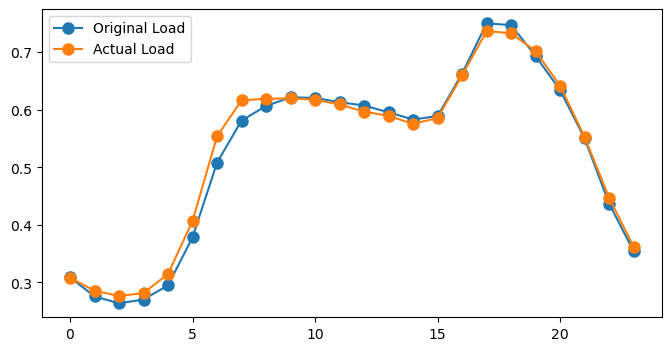

Inquiry 8: No valid strategy found, using original curve as fine-tuned result.
2806.2167073697315
2758.102349215448
2756.316953300639


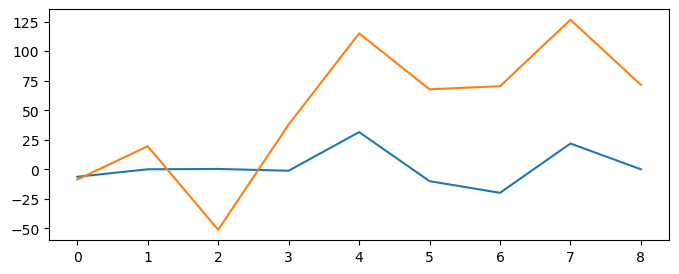

Processing inquiry 10/29
Similar days original cost: 2750.0715639483033 Similar days optnet cost: 2800.960836375465
Found 3 similar days for inquiry 9
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2742.43, original cost 2750.07, (reduction 7.64)
Discovered valid strategy strategy_4, cost 2743.97, original cost 2750.07, (reduction 6.10)
Discovered valid strategy strategy_6, cost 2746.61, original cost 2750.07, (reduction 3.47)
Discovered valid strategy strategy_9, cost 2745.46, original cost 2750.07, (reduction 4.61)
Discovered valid strategy strategy_10, cost 2743.06, original cost 2750.07, (reduction 7.01)
Strategy generation attempt #2 (Current valid strategies: 5/20)
Discovered valid strategy strategy_1, cost 2742.43, original cost 2750.07, (reduction 7.64)
Discovered valid strategy strategy_4, cost 2740.85, original cost 2750.07, (reduction 9.22)
Discovered valid strate

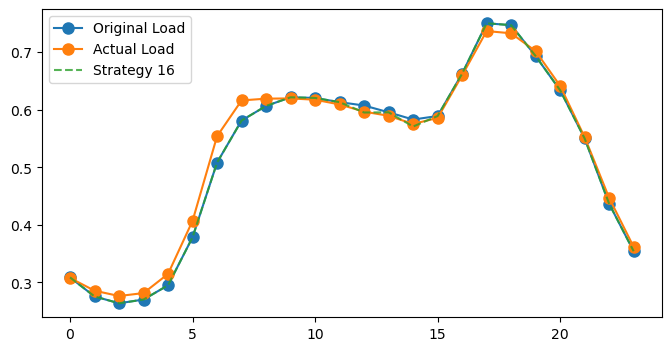

Found 1 relevant failed reflection cases for inquiry 9


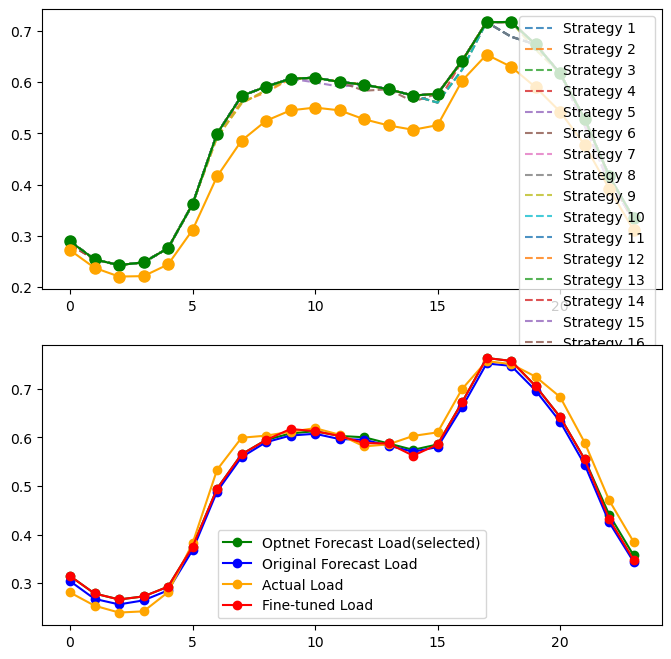

Original cost: 2951.0416807476286, Optnet cost: 2877.2382695198658, Fine-tuned cost: 2894.27245453344
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_2, cost 2935.36, original cost 2951.04, (reduction 15.68)
Discovered valid strategy strategy_7, cost 2934.90, original cost 2951.04, (reduction 16.15)
Discovered valid strategy strategy_10, cost 2943.19, original cost 2951.04, (reduction 7.85)
Strategy generation attempt #2 (Current valid strategies: 3/5)
Providing actual load values
Discovered valid strategy strategy_2, cost 2935.36, original cost 2951.04, (reduction 15.68)
Discovered valid strategy strategy_4, cost 2943.19, original cost 2951.04, (reduction 7.85)
2820.699204707521
2770.0159412458897
2770.112503423919


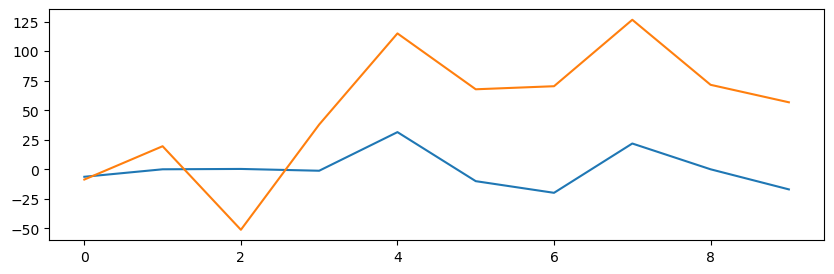

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [1, 8]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 11/29
Similar days original cost: 2720.589481968145 Similar days optnet cost: 2773.461922691524
Found 3 similar days for inquiry 10
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2710.52, original cost 2720.59, (reduction 10.07)
Strategy generation attempt #2 (Current valid strategies: 1/20)
Discovered valid strategy strategy_1, cost 2710.52, original cost 2720.59, (reduction 10.07)
Discovered valid strategy strategy_5, cost 2711.02, original cost 2720.59, (reduction 9.57)
Discovered valid strategy strategy_8, cost 2711.83, original cost 2720.59, (reduction 8.76)
Discovered valid strategy strategy_10, cost 2708.96, orig

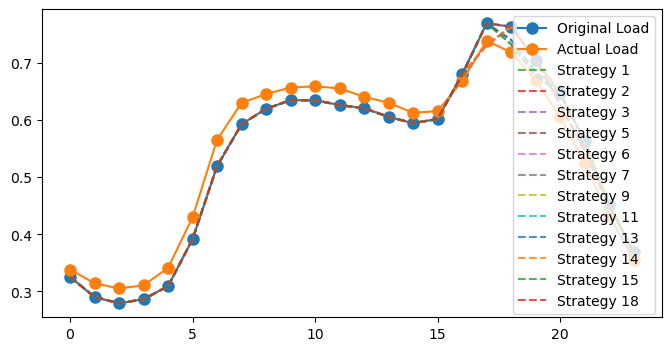

Found 1 relevant failed reflection cases for inquiry 10


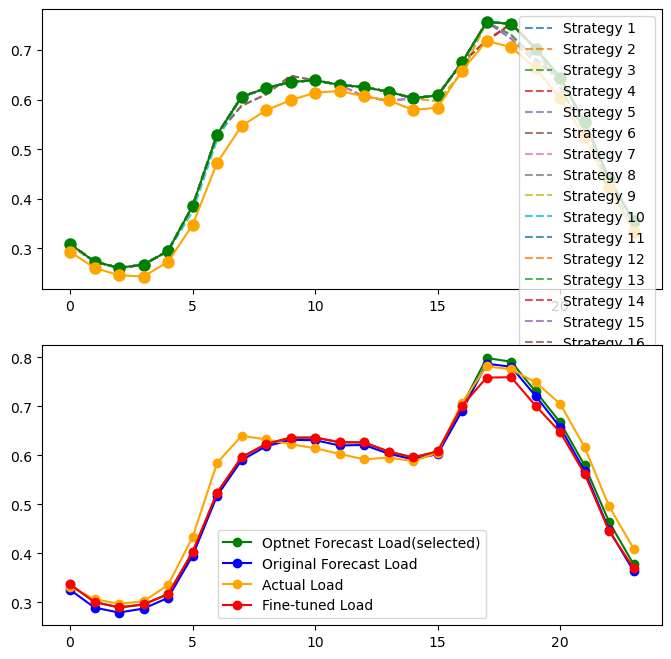

Original cost: 3033.3861763555406, Optnet cost: 2947.9905699509977, Fine-tuned cost: 3032.6190571026627
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_3, cost 3023.41, original cost 3033.39, (reduction 9.97)
Strategy generation attempt #2 (Current valid strategies: 1/5)
Providing actual load values
Discovered valid strategy strategy_2, cost 3028.28, original cost 3033.39, (reduction 5.10)
Discovered valid strategy strategy_3, cost 3023.41, original cost 3033.39, (reduction 9.97)
Discovered valid strategy strategy_7, cost 3017.18, original cost 3033.39, (reduction 16.21)
Strategy generation attempt #3 (Current valid strategies: 4/5)
Providing actual load values
Discovered valid strategy strategy_2, cost 3028.28, original cost 3033.39, (reduction 5.10)
2840.0343839482503
2786.195452946354
2793.976735576532


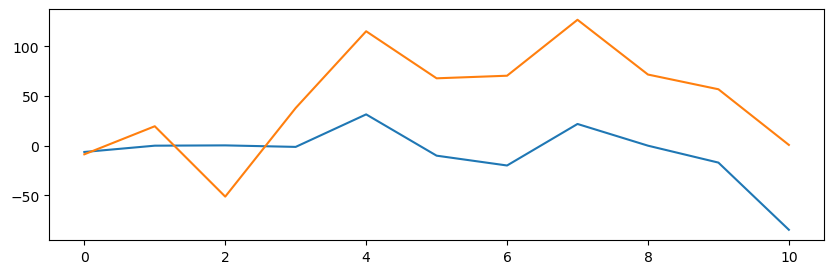

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [1, 8]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 12/29
Similar days original cost: 2815.76591800187 Similar days optnet cost: 2823.640954253117
Found 3 similar days for inquiry 11
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2807.34, original cost 2815.77, (reduction 8.43)
Discovered valid strategy strategy_2, cost 2800.15, original cost 2815.77, (reduction 15.61)
Discovered valid strategy strategy_4, cost 2813.46, original cost 2815.77, (reduction 2.30)
Discovered valid strategy strategy_9, cost 2809.61, original cost 2815.77, (reduction 6.16)
Strategy generation attempt #2 (Current valid strategies: 4/20)
Discovered valid strategy strategy_1, cost 2807.34, origina

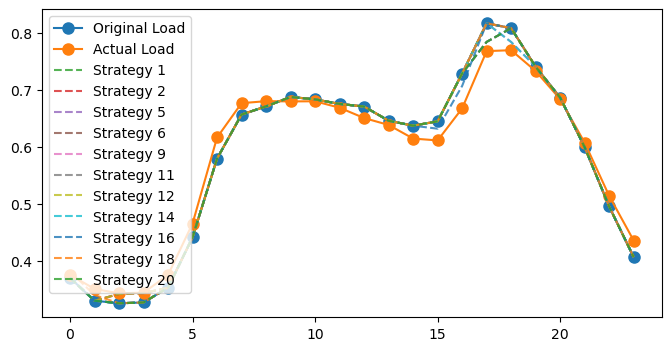

Found 1 relevant failed reflection cases for inquiry 11


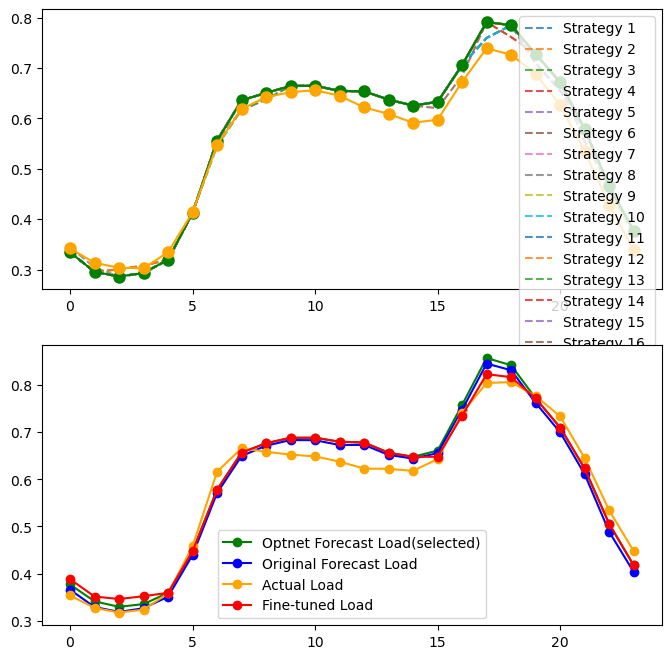

Original cost: 3001.612160353601, Optnet cost: 2967.6584888739585, Fine-tuned cost: 2961.965513473809
2853.499198648696
2801.3173726069876
2807.975800401305


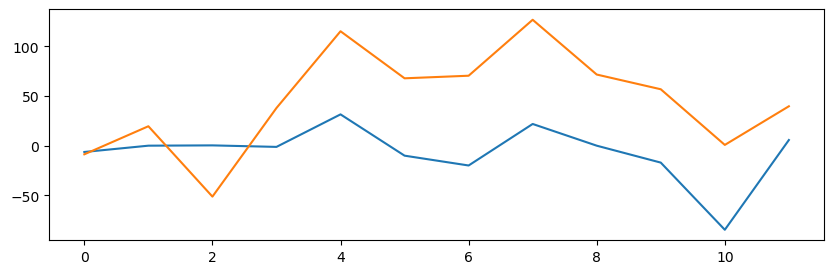

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [1, 8]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 13/29
Similar days original cost: 2815.76591800187 Similar days optnet cost: 2823.640954253117
Found 3 similar days for inquiry 12
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_2, cost 2799.28, original cost 2815.77, (reduction 16.49)
Discovered valid strategy strategy_7, cost 2813.95, original cost 2815.77, (reduction 1.82)
Discovered valid strategy strategy_9, cost 2808.82, original cost 2815.77, (reduction 6.94)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_1, cost 2801.07, original cost 2815.77, (reduction 14.69)
Discovered valid strategy strategy_2, cost 2799.28, origin

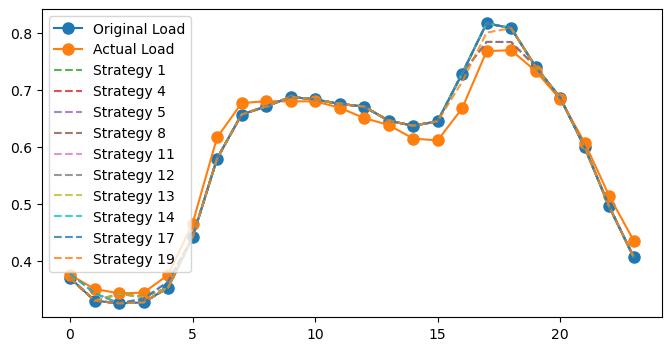

Found 1 relevant failed reflection cases for inquiry 12


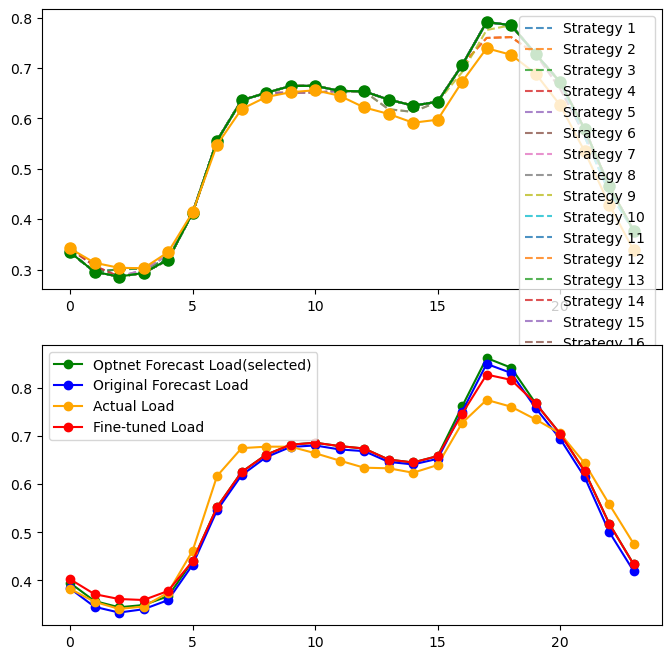

Original cost: 3091.9744719560144, Optnet cost: 3038.6978486726885, Fine-tuned cost: 3027.221856832766
2871.8434504415663
2819.5774092274264
2824.8408816652636


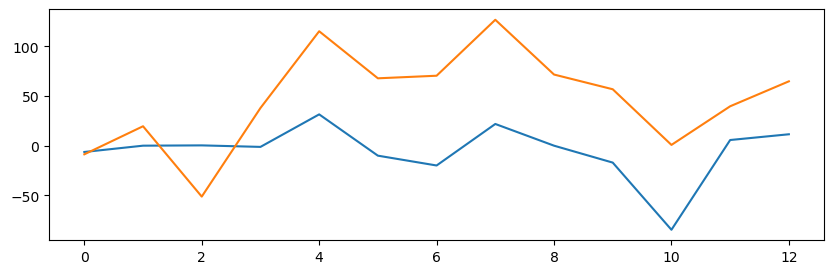

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [1, 8]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 14/29
Similar days original cost: 2746.4552264762524 Similar days optnet cost: 2755.3602366184796
Found 3 similar days for inquiry 13
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2735.96, original cost 2746.46, (reduction 10.50)
Discovered valid strategy strategy_2, cost 2737.39, original cost 2746.46, (reduction 9.06)
Discovered valid strategy strategy_5, cost 2737.64, original cost 2746.46, (reduction 8.82)
Discovered valid strategy strategy_6, cost 2733.87, original cost 2746.46, (reduction 12.58)
Discovered valid strategy strategy_10, cost 2741.51, original cost 2746.46, (reduction 4.95)
Strategy generation attemp

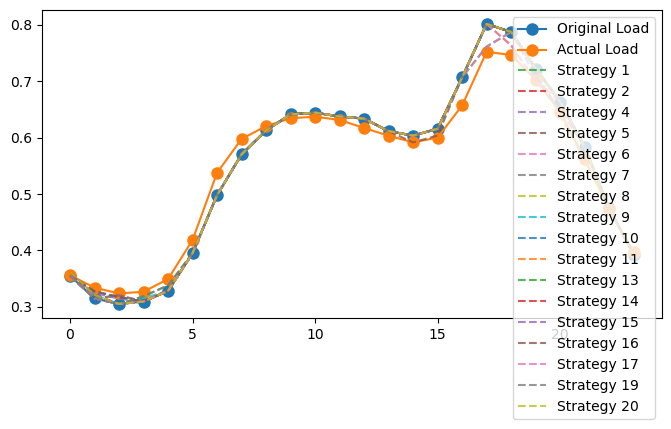

Found 1 relevant failed reflection cases for inquiry 13


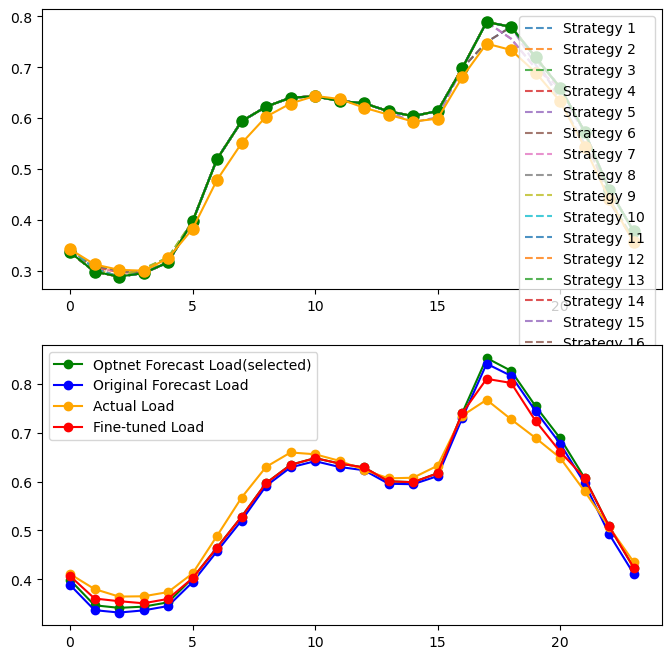

Original cost: 3060.7738320928215, Optnet cost: 2978.065191516817, Fine-tuned cost: 2909.457204537165
2885.3384777023703
2830.89796510524
2830.8849047275426


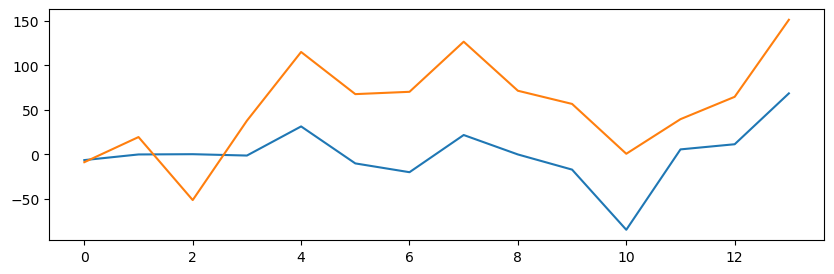

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [1, 8]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 15/29
Similar days original cost: 2699.0273535826404 Similar days optnet cost: 2738.321677025219
Found 3 similar days for inquiry 14
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2688.81, original cost 2699.03, (reduction 10.22)
Discovered valid strategy strategy_2, cost 2695.76, original cost 2699.03, (reduction 3.27)
Discovered valid strategy strategy_5, cost 2694.75, original cost 2699.03, (reduction 4.28)
Discovered valid strategy strategy_6, cost 2695.74, original cost 2699.03, (reduction 3.28)
Discovered valid strategy strategy_7, cost 2692.22, original cost 2699.03, (reduction 6.81)
Strategy generation attempt #

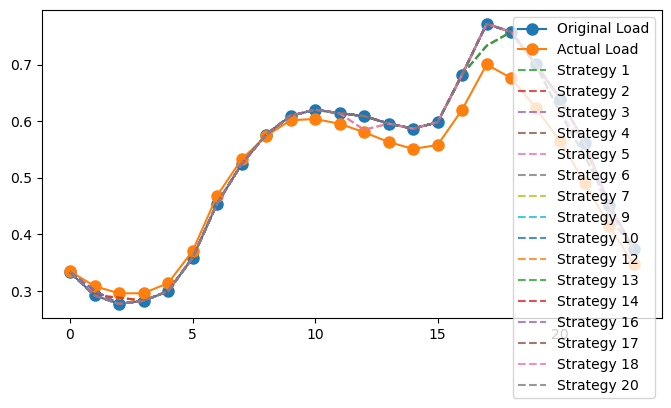

Found 0 relevant failed reflection cases for inquiry 14


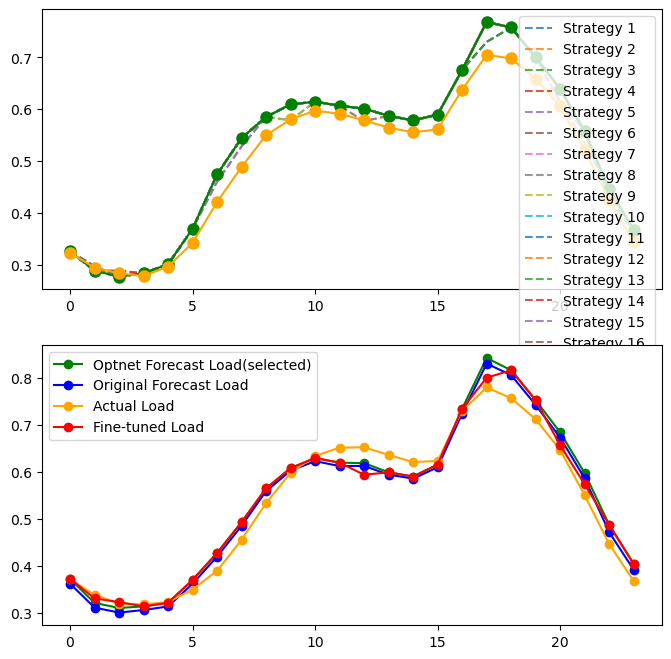

Original cost: 2886.3691417390705, Optnet cost: 2858.1269902995828, Fine-tuned cost: 2837.945805627704
2885.4071886381503
2832.7132334515295
2831.35563145422


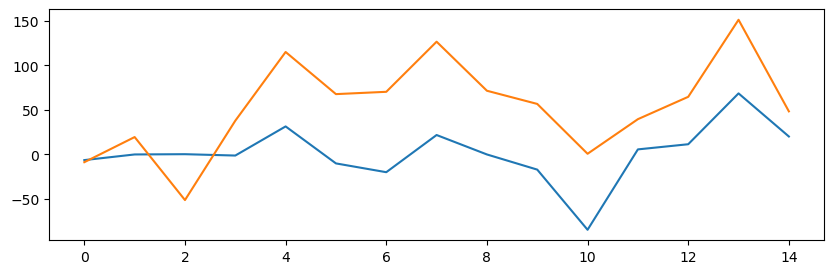

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [1, 8]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 16/29
Similar days original cost: 2815.76591800187 Similar days optnet cost: 2823.640954253117
Found 3 similar days for inquiry 15
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2805.23, original cost 2815.77, (reduction 10.53)
Discovered valid strategy strategy_2, cost 2807.60, original cost 2815.77, (reduction 8.17)
Discovered valid strategy strategy_5, cost 2806.82, original cost 2815.77, (reduction 8.94)
Discovered valid strategy strategy_6, cost 2804.84, original cost 2815.77, (reduction 10.93)
Discovered valid strategy strategy_8, cost 2811.85, original cost 2815.77, (reduction 3.92)
Strategy generation attempt #2

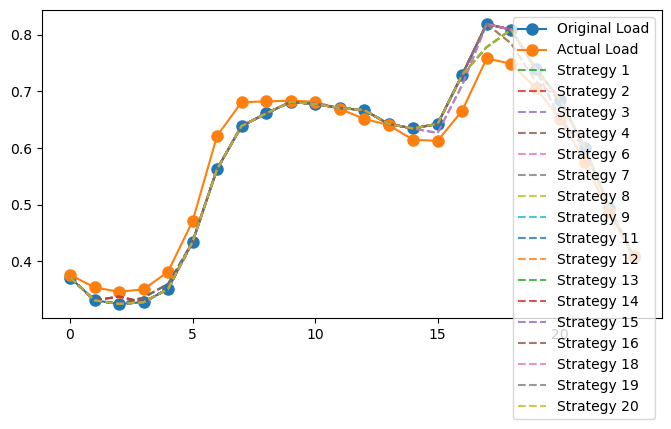

Found 0 relevant failed reflection cases for inquiry 15


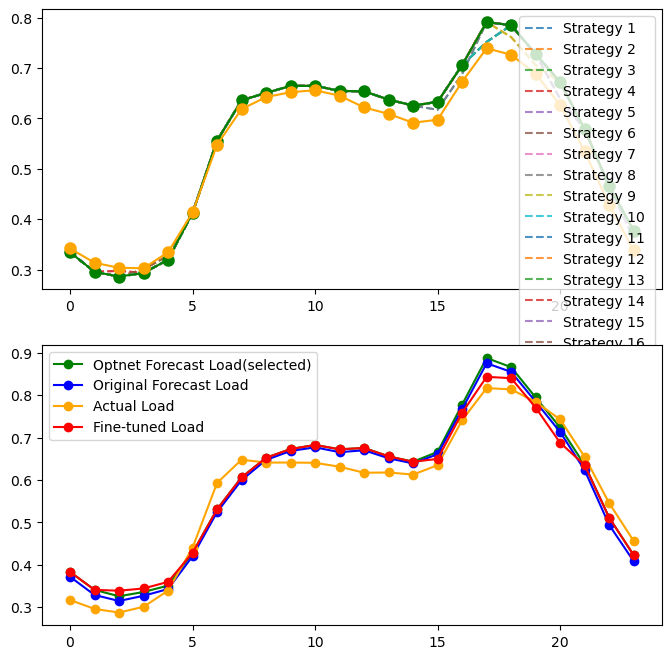

Original cost: 3059.438257263124, Optnet cost: 3042.3013023434282, Fine-tuned cost: 3054.0111917119916
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_1, cost 3047.79, original cost 3059.44, (reduction 11.65)
Discovered valid strategy strategy_3, cost 3048.04, original cost 3059.44, (reduction 11.40)
Strategy generation attempt #2 (Current valid strategies: 2/5)
Providing actual load values
Discovered valid strategy strategy_1, cost 3047.79, original cost 3059.44, (reduction 11.65)
Discovered valid strategy strategy_3, cost 3049.36, original cost 3059.44, (reduction 10.08)
Discovered valid strategy strategy_6, cost 3037.76, original cost 3059.44, (reduction 21.68)
2896.2841304272115
2845.812487757273
2845.271603970331


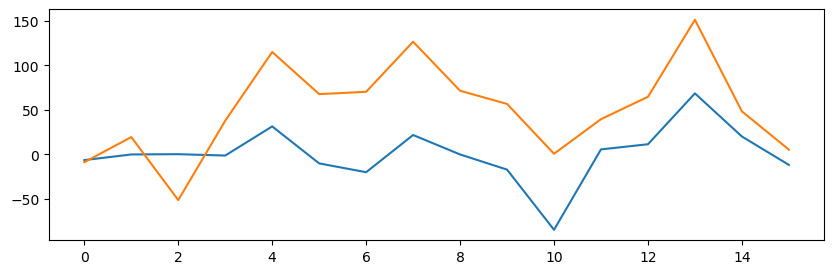

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [1, 8]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 17/29
Similar days original cost: 2925.269474831035 Similar days optnet cost: 2947.817038541128
Found 3 similar days for inquiry 16
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2914.72, original cost 2925.27, (reduction 10.55)
Discovered valid strategy strategy_2, cost 2915.14, original cost 2925.27, (reduction 10.13)
Discovered valid strategy strategy_4, cost 2916.87, original cost 2925.27, (reduction 8.40)
Discovered valid strategy strategy_7, cost 2916.40, original cost 2925.27, (reduction 8.87)
Discovered valid strategy strategy_9, cost 2919.54, original cost 2925.27, (reduction 5.73)
Strategy generation attempt #

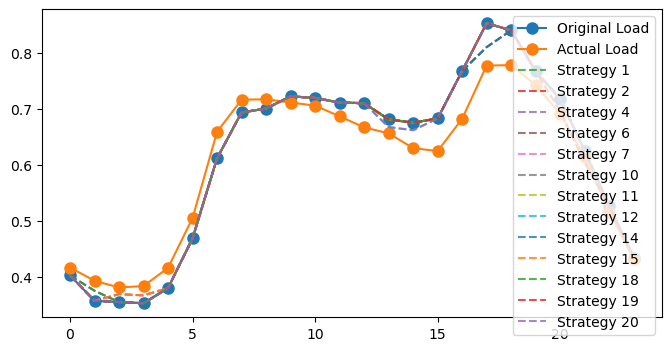

Found 0 relevant failed reflection cases for inquiry 16


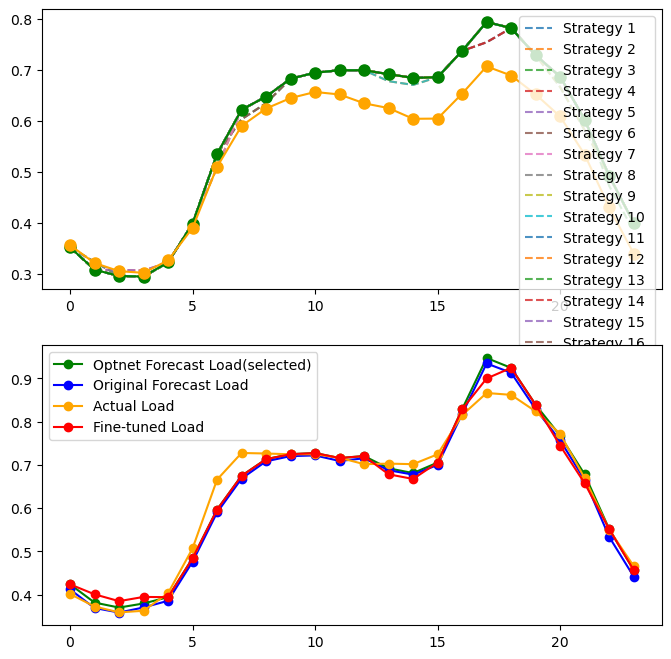

Original cost: 3154.8055843421816, Optnet cost: 3103.8846212369203, Fine-tuned cost: 3145.4495916405795
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_1, cost 3142.37, original cost 3154.81, (reduction 12.43)
Discovered valid strategy strategy_8, cost 3136.44, original cost 3154.81, (reduction 18.37)
Strategy generation attempt #2 (Current valid strategies: 2/5)
Providing actual load values
Discovered valid strategy strategy_1, cost 3142.37, original cost 3154.81, (reduction 12.43)
Discovered valid strategy strategy_4, cost 3125.87, original cost 3154.81, (reduction 28.94)
Strategy generation attempt #3 (Current valid strategies: 4/5)
Providing actual load values
Discovered valid strategy strategy_1, cost 3142.37, original cost 3154.81, (reduction 12.43)
2911.491274775151
2860.9932014913697
2862.9291326568164


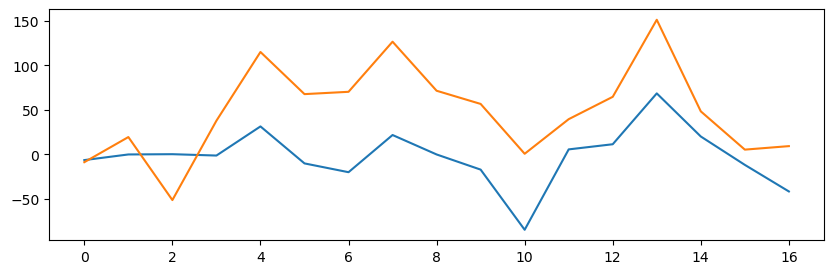

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [1, 8]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 18/29
Similar days original cost: 2925.269474831035 Similar days optnet cost: 2947.817038541128
Found 3 similar days for inquiry 17
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_2, cost 2920.56, original cost 2925.27, (reduction 4.71)
Discovered valid strategy strategy_3, cost 2913.98, original cost 2925.27, (reduction 11.29)
Discovered valid strategy strategy_8, cost 2917.70, original cost 2925.27, (reduction 7.57)
Discovered valid strategy strategy_10, cost 2917.39, original cost 2925.27, (reduction 7.88)
Strategy generation attempt #2 (Current valid strategies: 4/20)
Discovered valid strategy strategy_1, cost 2914.72, origi

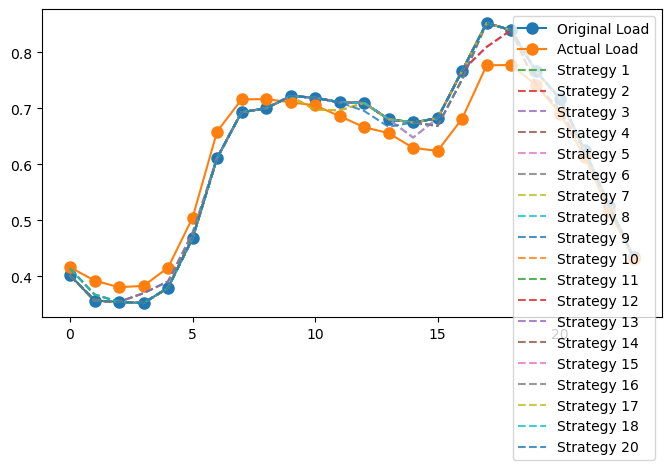

Found 0 relevant failed reflection cases for inquiry 17


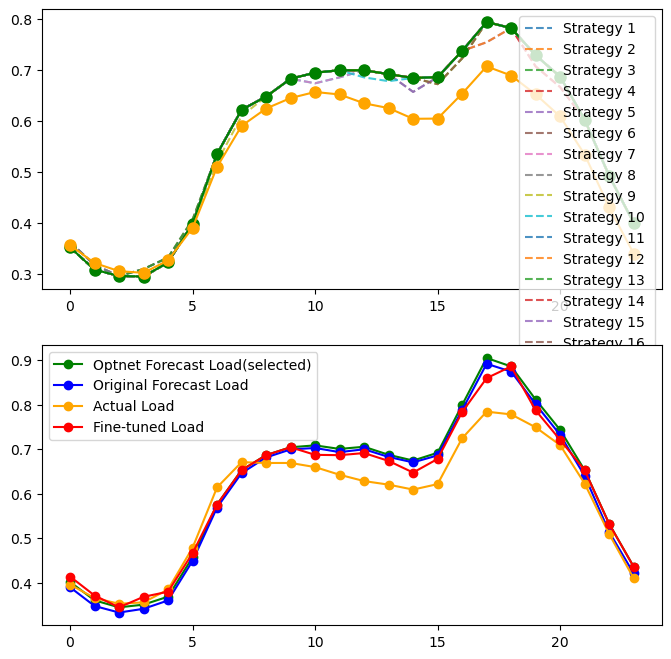

Original cost: 3067.174809405029, Optnet cost: 3058.0413363064526, Fine-tuned cost: 2987.8170967691394
2920.1403600323665
2871.940320092208
2869.8673528852787


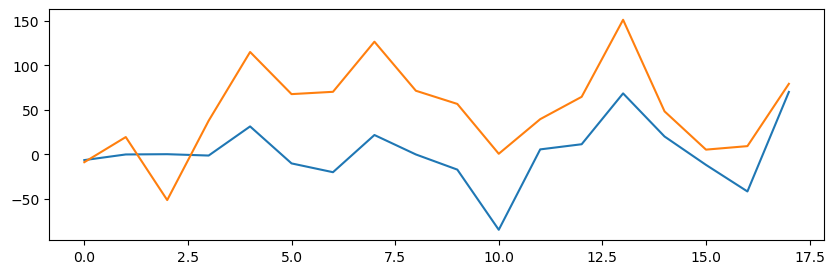

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [1, 8]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 19/29
Similar days original cost: 2746.4552264762524 Similar days optnet cost: 2755.3602366184796
Found 3 similar days for inquiry 18
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2731.83, original cost 2746.46, (reduction 14.62)
Discovered valid strategy strategy_2, cost 2735.74, original cost 2746.46, (reduction 10.71)
Discovered valid strategy strategy_4, cost 2738.40, original cost 2746.46, (reduction 8.06)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_1, cost 2729.73, original cost 2746.46, (reduction 16.72)
Discovered valid strategy strategy_2, cost 2735.74, or

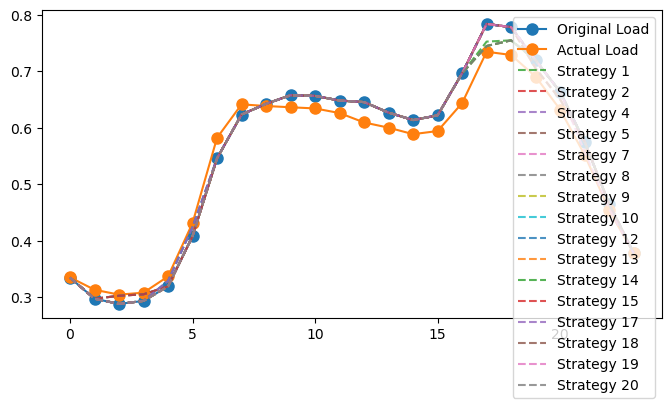

Found 0 relevant failed reflection cases for inquiry 18


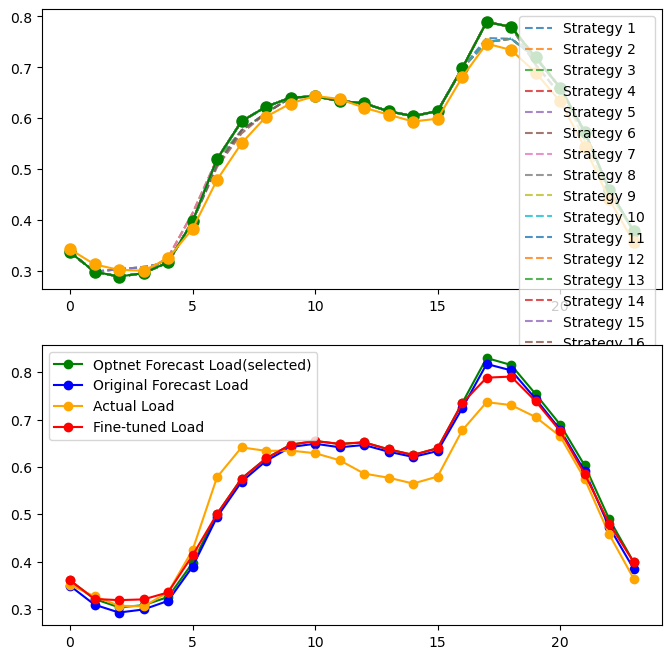

Original cost: 2976.491169150829, Optnet cost: 2968.5492071110607, Fine-tuned cost: 2921.5694222509924
2923.106192091233
2877.024998356358
2872.5885144308427


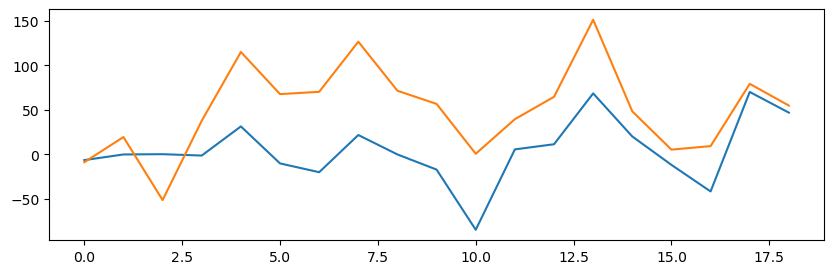

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [1, 8]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 20/29
Similar days original cost: 2684.6170184083385 Similar days optnet cost: 2733.791225679875
Found 3 similar days for inquiry 19
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2676.66, original cost 2684.62, (reduction 7.96)
Discovered valid strategy strategy_7, cost 2677.36, original cost 2684.62, (reduction 7.25)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Discovered valid strategy strategy_1, cost 2676.66, original cost 2684.62, (reduction 7.96)
Discovered valid strategy strategy_4, cost 2675.09, original cost 2684.62, (reduction 9.53)
Discovered valid strategy strategy_7, cost 2677.36, origin

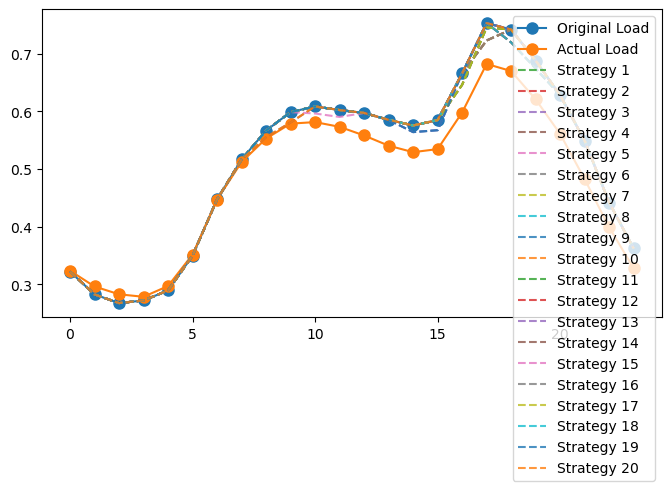

Found 0 relevant failed reflection cases for inquiry 19


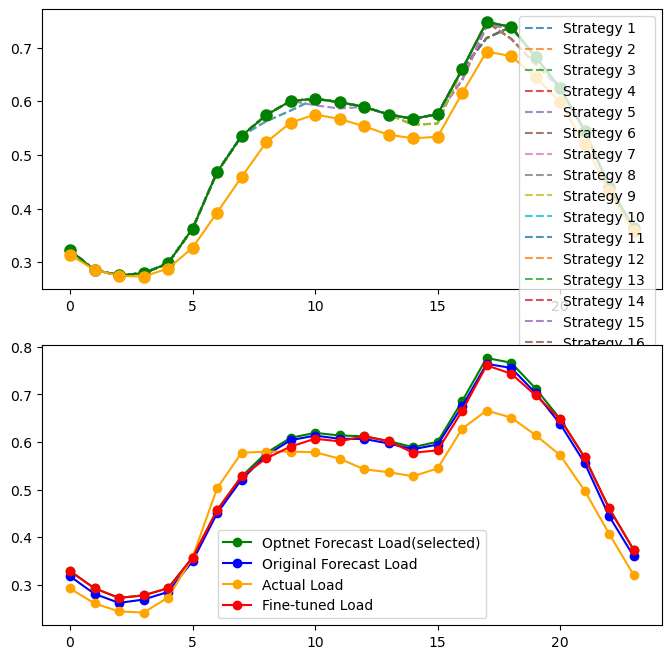

Original cost: 2826.9965489726364, Optnet cost: 2857.0903414242566, Fine-tuned cost: 2826.396184705102
2918.300709935303
2876.028265509753
2870.2788979445554


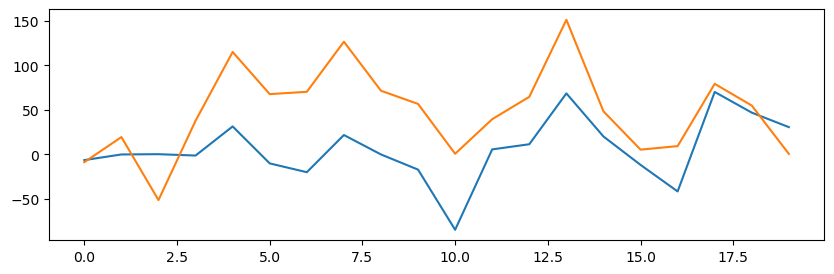

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [1, 8]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 21/29
Similar days original cost: 2572.142115977407 Similar days optnet cost: 2551.2794013604325
Found 3 similar days for inquiry 20
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_4, cost 2569.83, original cost 2572.14, (reduction 2.31)
Strategy generation attempt #2 (Current valid strategies: 1/20)
Discovered valid strategy strategy_4, cost 2569.83, original cost 2572.14, (reduction 2.31)
Discovered valid strategy strategy_7, cost 2553.11, original cost 2572.14, (reduction 19.03)
Discovered valid strategy strategy_8, cost 2567.71, original cost 2572.14, (reduction 4.44)
Strategy generation attempt #3 (Current valid strategies:

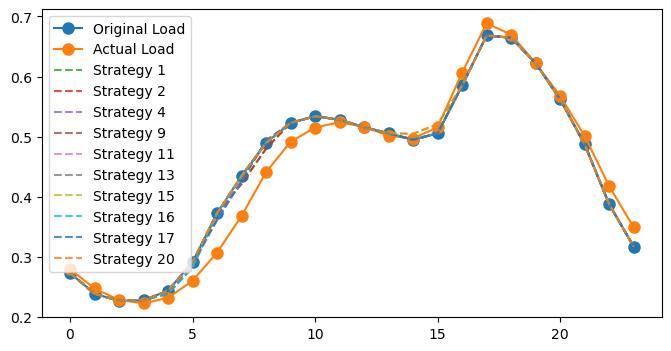

Found 0 relevant failed reflection cases for inquiry 20


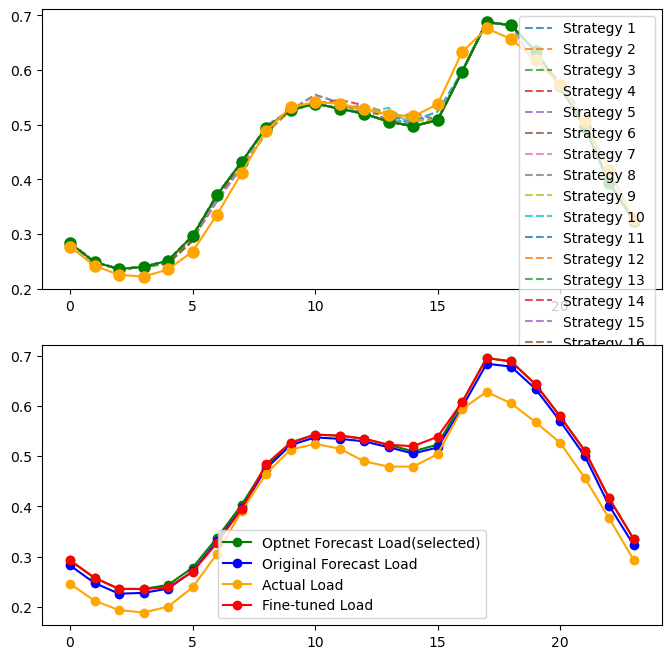

Original cost: 2519.914723799348, Optnet cost: 2571.306141859889, Fine-tuned cost: 2570.9366206553814
2899.3299486907335
2861.517688193093
2856.024503787928


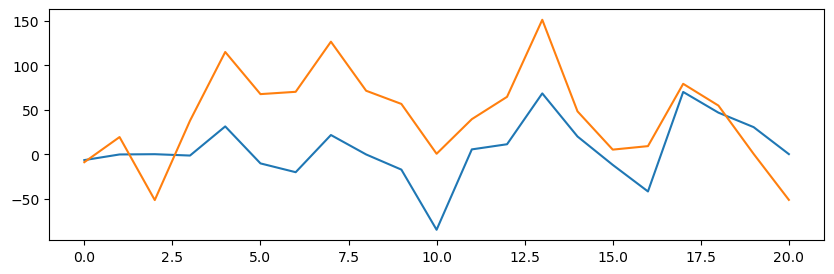

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [1, 8]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 22/29
Similar days original cost: 2572.690603984793 Similar days optnet cost: 2544.688111611983
Found 3 similar days for inquiry 21
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2571.58, original cost 2572.69, (reduction 1.11)
Discovered valid strategy strategy_2, cost 2565.08, original cost 2572.69, (reduction 7.61)
Discovered valid strategy strategy_5, cost 2563.70, original cost 2572.69, (reduction 8.99)
Discovered valid strategy strategy_6, cost 2566.73, original cost 2572.69, (reduction 5.96)
Discovered valid strategy strategy_7, cost 2558.94, original cost 2572.69, (reduction 13.75)
Discovered valid strategy stra

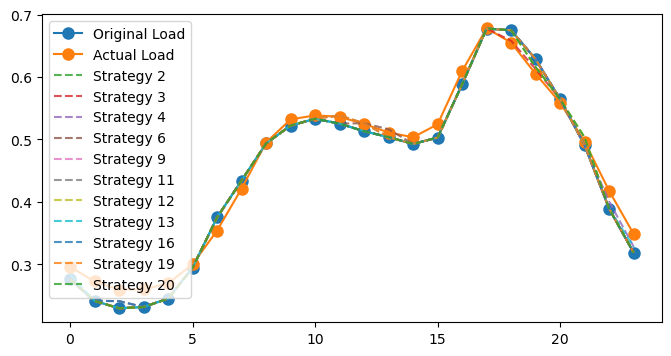

Found 1 relevant failed reflection cases for inquiry 21


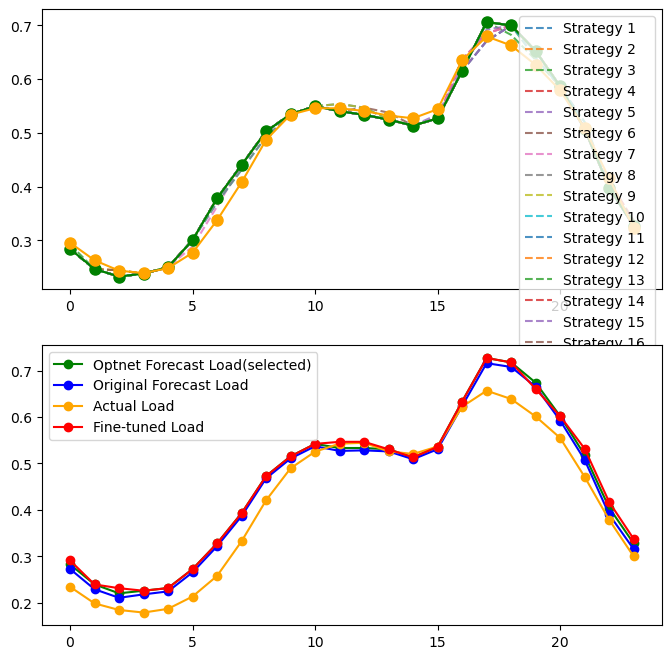

Original cost: 2559.0792721230982, Optnet cost: 2589.115245248795, Fine-tuned cost: 2586.974037123221
2883.8640088467505
2849.135758968352
2843.7949371213504


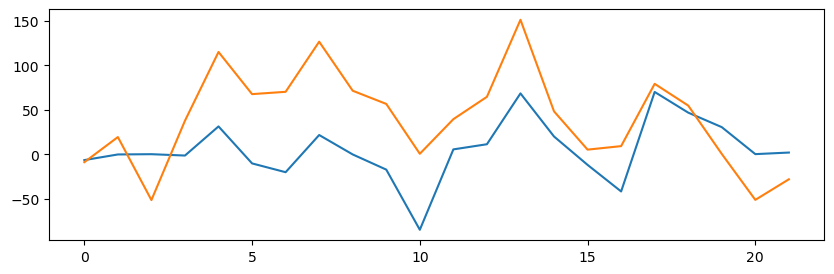

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [1, 8]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 23/29
Similar days original cost: 2660.5250274672408 Similar days optnet cost: 2709.5146791682737
Found 3 similar days for inquiry 22
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2651.00, original cost 2660.53, (reduction 9.53)
Strategy generation attempt #2 (Current valid strategies: 1/20)
Discovered valid strategy strategy_1, cost 2651.00, original cost 2660.53, (reduction 9.53)
Strategy generation attempt #3 (Current valid strategies: 2/20)
Providing actual load values
Discovered valid strategy strategy_1, cost 2651.00, original cost 2660.53, (reduction 9.53)
Discovered valid strategy strategy_5, cost 2651.51, orig

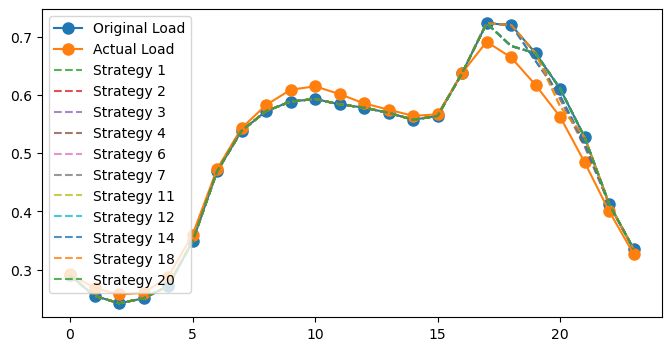

Found 1 relevant failed reflection cases for inquiry 22


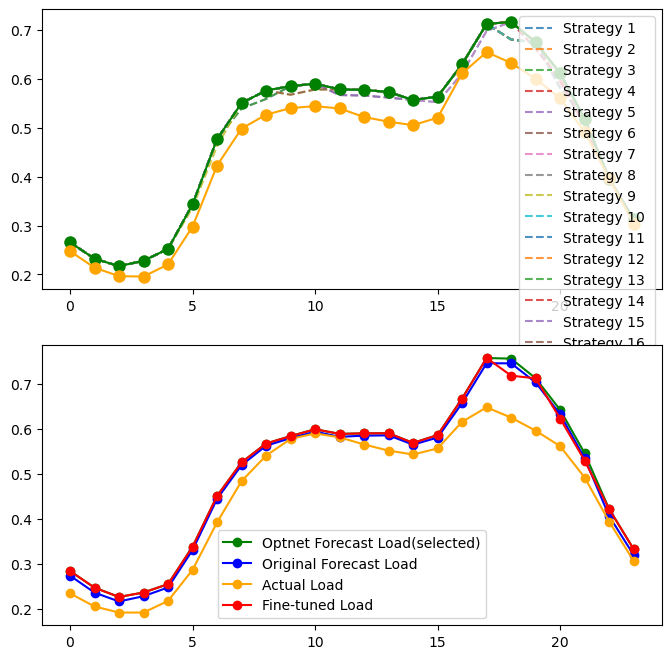

Original cost: 2667.2827522518037, Optnet cost: 2719.652410036385, Fine-tuned cost: 2700.083964994025
2874.4474324730572
2843.506048145223
2837.5466339853797


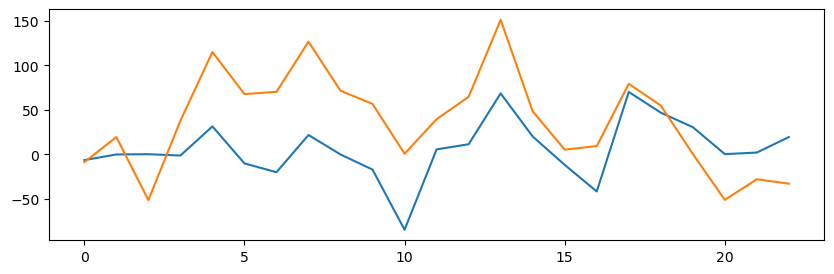

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [1, 8]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 24/29
Similar days original cost: 2669.0128782145975 Similar days optnet cost: 2713.8444004385274
Found 3 similar days for inquiry 23
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2663.28, original cost 2669.01, (reduction 5.73)
Discovered valid strategy strategy_5, cost 2661.84, original cost 2669.01, (reduction 7.17)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Discovered valid strategy strategy_1, cost 2663.28, original cost 2669.01, (reduction 5.73)
Discovered valid strategy strategy_2, cost 2661.84, original cost 2669.01, (reduction 7.17)
Discovered valid strategy strategy_4, cost 2656.89, origi

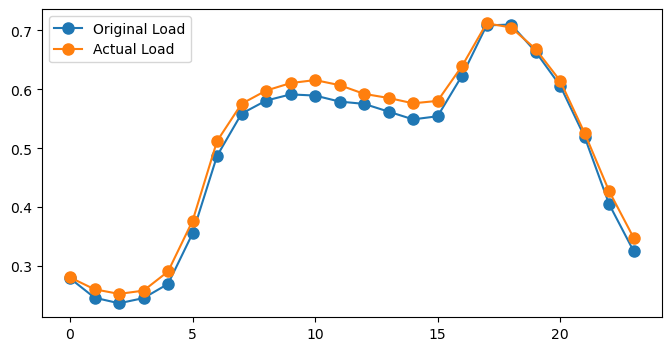

Inquiry 23: No valid strategy found, using original curve as fine-tuned result.
2873.260477551957
2844.5692746752648
2838.858169438749


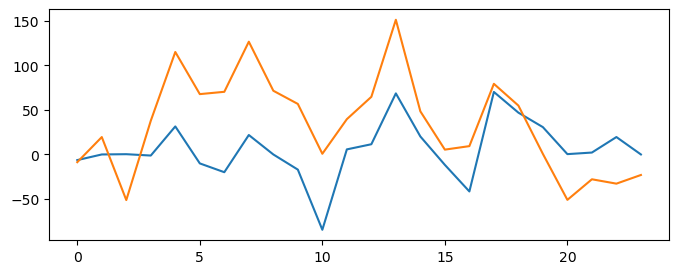

Processing inquiry 25/29
Similar days original cost: 2576.9036490192316 Similar days optnet cost: 2574.7032548169395
Found 3 similar days for inquiry 24
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_9, cost 2575.54, original cost 2576.90, (reduction 1.36)
Strategy generation attempt #2 (Current valid strategies: 1/20)
Discovered valid strategy strategy_4, cost 2572.56, original cost 2576.90, (reduction 4.34)
Discovered valid strategy strategy_8, cost 2570.95, original cost 2576.90, (reduction 5.95)
Discovered valid strategy strategy_9, cost 2575.54, original cost 2576.90, (reduction 1.36)
Strategy generation attempt #3 (Current valid strategies: 4/20)
Providing actual load values
Discovered valid strategy strategy_4, cost 2569.34, original cost 2576.90, (reduction 7.57)
Discovered valid strategy strategy_7, cost 2560.71, original cost 2576.90, (reduction 16.19)
Discovered valid str

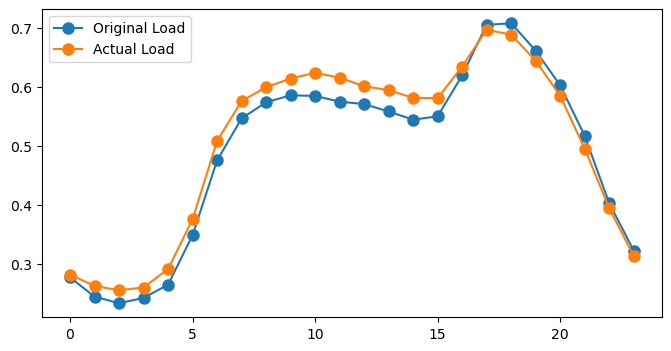

Inquiry 24: No valid strategy found, using original curve as fine-tuned result.
2871.3062751884677
2843.016296171527
2837.5336351444716


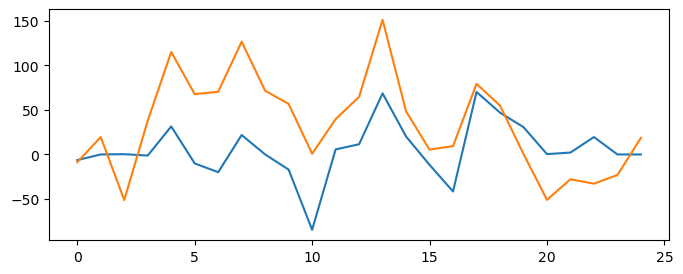

Processing inquiry 26/29
Similar days original cost: 2620.9823405791612 Similar days optnet cost: 2583.962242279977
Found 3 similar days for inquiry 25
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2613.57, original cost 2620.98, (reduction 7.42)
Discovered valid strategy strategy_2, cost 2614.25, original cost 2620.98, (reduction 6.74)
Discovered valid strategy strategy_5, cost 2613.22, original cost 2620.98, (reduction 7.76)
Discovered valid strategy strategy_7, cost 2615.78, original cost 2620.98, (reduction 5.20)
Discovered valid strategy strategy_10, cost 2614.98, original cost 2620.98, (reduction 6.00)
Strategy generation attempt #2 (Current valid strategies: 5/20)
Discovered valid strategy strategy_1, cost 2613.57, original cost 2620.98, (reduction 7.42)
Discovered valid strategy strategy_2, cost 2614.25, original cost 2620.98, (reduction 6.74)
Discovered valid strat

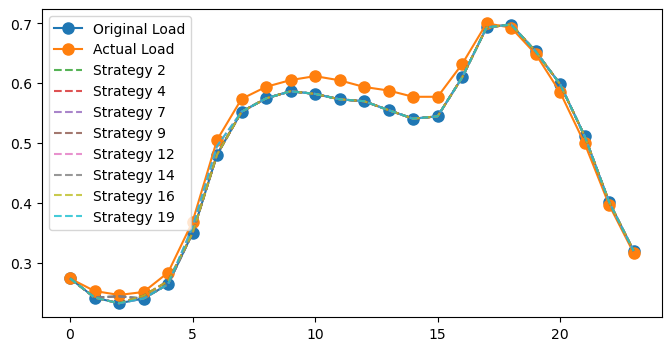

Found 1 relevant failed reflection cases for inquiry 25


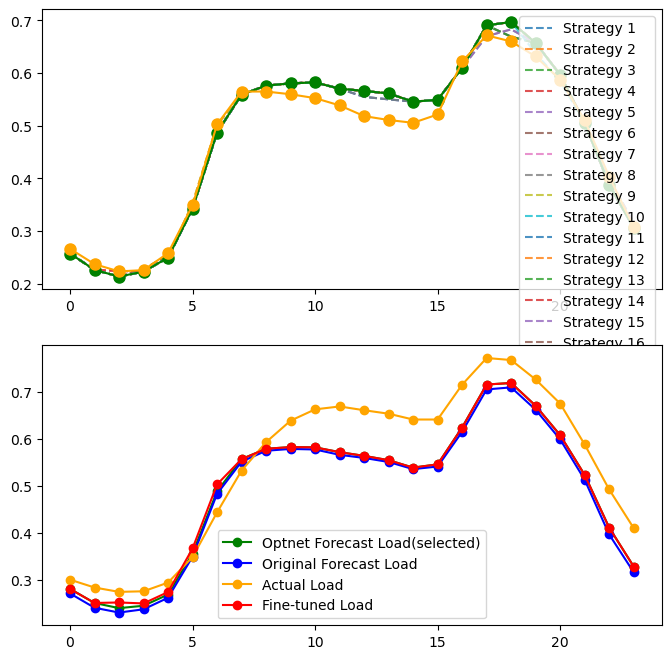

Original cost: 3708.977971447289, Optnet cost: 3599.360270661175, Fine-tuned cost: 3590.094313591254
2903.5244173522683
2872.106449036513
2866.4782766231942


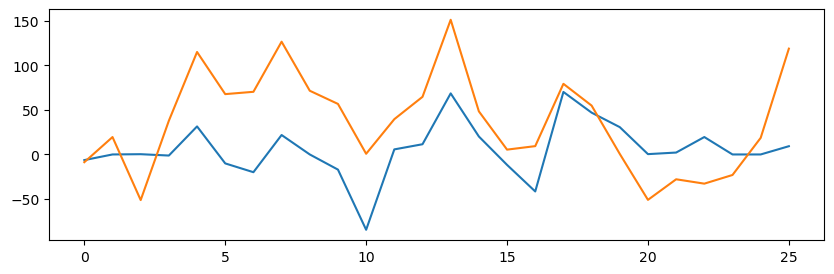

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [1, 8, 23, 24]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 27/29
Similar days original cost: 2815.76591800187 Similar days optnet cost: 2823.640954253117
Found 3 similar days for inquiry 26
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2807.34, original cost 2815.77, (reduction 8.43)
Discovered valid strategy strategy_2, cost 2805.56, original cost 2815.77, (reduction 10.21)
Discovered valid strategy strategy_5, cost 2812.62, original cost 2815.77, (reduction 3.14)
Discovered valid strategy strategy_6, cost 2803.21, original cost 2815.77, (reduction 12.55)
Strategy generation attempt #2 (Current valid strategies: 4/20)
Discovered valid strategy strategy_1, cost 2805.23

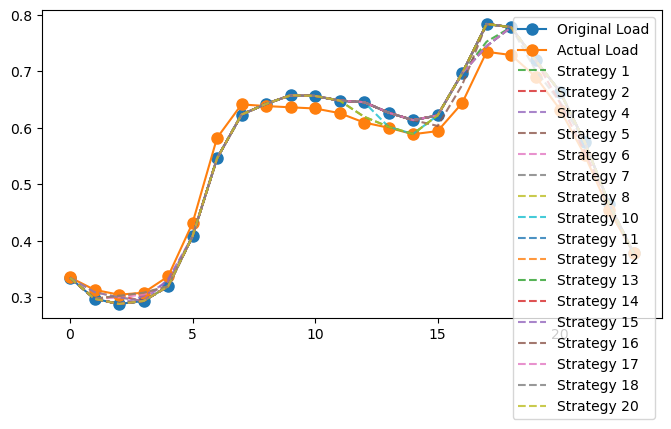

Found 1 relevant failed reflection cases for inquiry 26


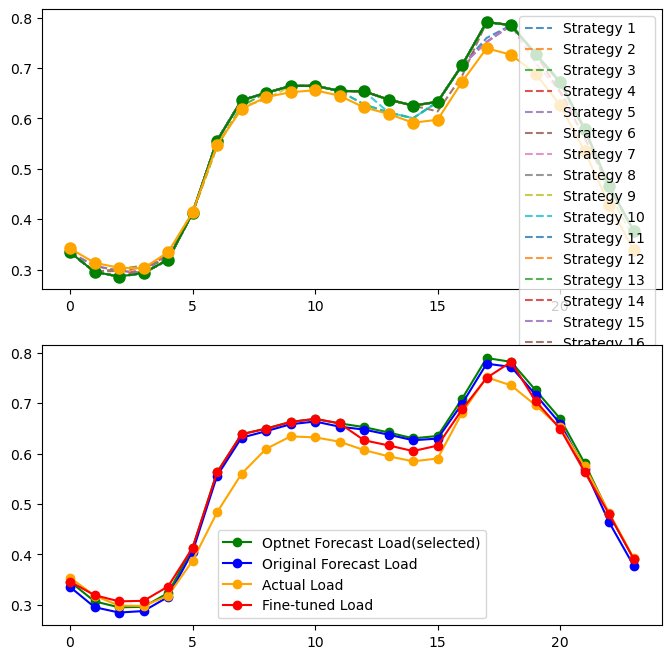

Original cost: 2837.3461347178218, Optnet cost: 2814.011486024797, Fine-tuned cost: 2768.241176039809
2901.0733698472886
2869.954783739783
2862.8398654904763


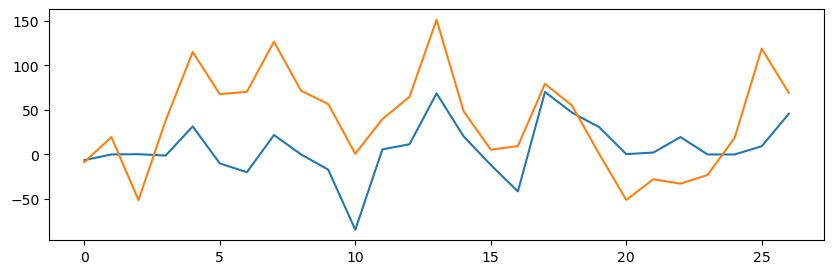

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [1, 8, 23, 24]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 28/29
Similar days original cost: 2558.225305098057 Similar days optnet cost: 2604.3764364105064
Found 3 similar days for inquiry 27
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2551.42, original cost 2558.23, (reduction 6.81)
Discovered valid strategy strategy_4, cost 2547.28, original cost 2558.23, (reduction 10.94)
Discovered valid strategy strategy_6, cost 2552.69, original cost 2558.23, (reduction 5.54)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_1, cost 2551.42, original cost 2558.23, (reduction 6.81)
Discovered valid strategy strategy_3, cost 2554.3

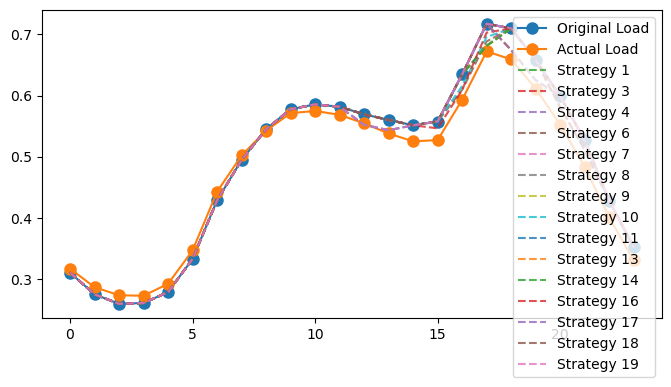

Found 1 relevant failed reflection cases for inquiry 27


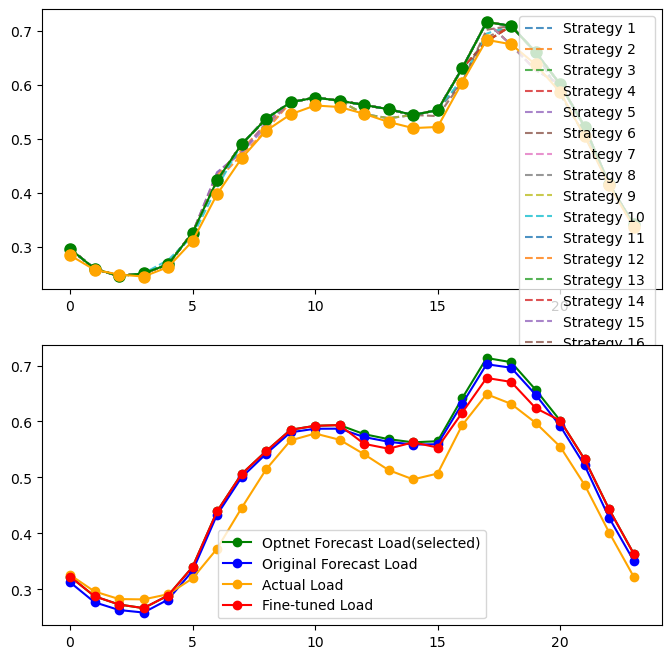

Original cost: 2690.5107073206304, Optnet cost: 2696.7482804403307, Fine-tuned cost: 2650.149475880456
2893.553274757051
2863.7688371933737
2855.2437801472615


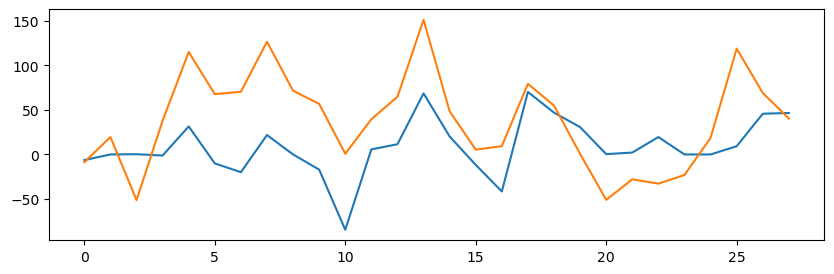

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [1, 8, 23, 24]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 29/29
Similar days original cost: 2572.690603984793 Similar days optnet cost: 2544.688111611983
Found 3 similar days for inquiry 28
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2566.59, original cost 2572.69, (reduction 6.10)
Discovered valid strategy strategy_2, cost 2556.28, original cost 2572.69, (reduction 16.41)
Discovered valid strategy strategy_4, cost 2566.50, original cost 2572.69, (reduction 6.19)
Discovered valid strategy strategy_5, cost 2565.92, original cost 2572.69, (reduction 6.77)
Discovered valid strategy strategy_8, cost 2556.04, original cost 2572.69, (reduction 16.65)
Strategy generation a

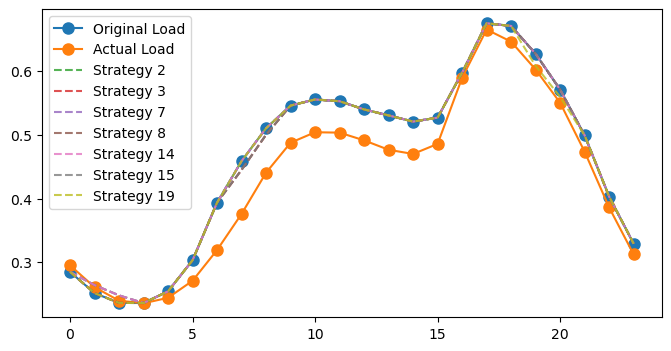

Found 1 relevant failed reflection cases for inquiry 28


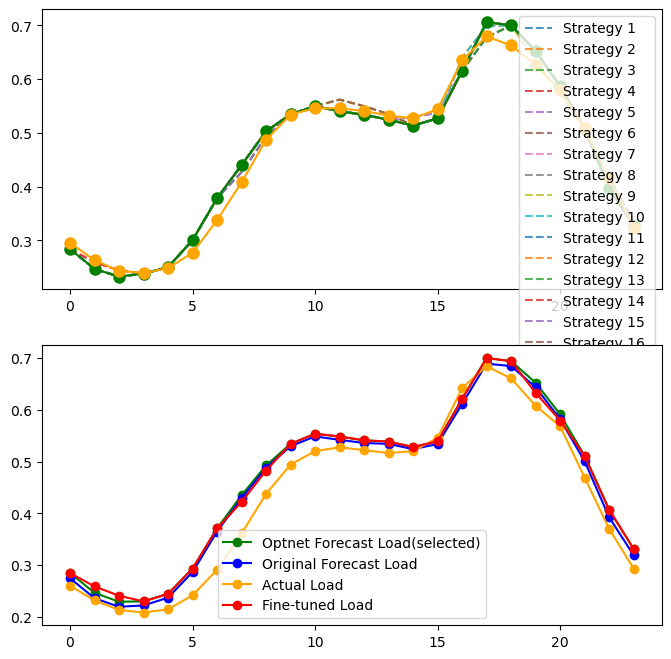

Original cost: 2545.1651810404655, Optnet cost: 2580.4118072267174, Fine-tuned cost: 2572.1395997424866
2881.5398922151003
2853.997905125558
2845.4815670298553


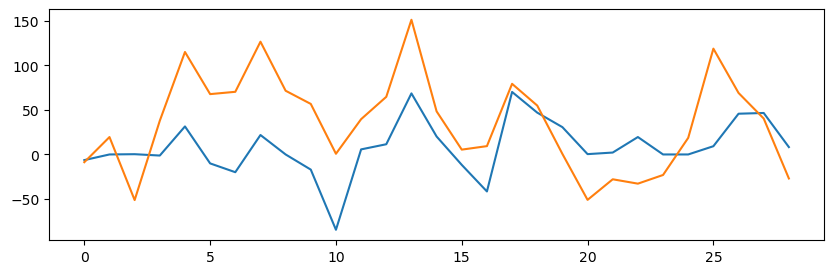

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [1, 8, 23, 24]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []


In [ ]:
fine_tuned_result_given_by_LLM = {
    'selected_flag': [], 'original_load': [], 'optnet_load': [], 'fine_tuned_load': [], 
    'cost_org': [], 'cost_optnet': [], 'cost_after': [], 'actual_load': [],
    'few_shot_curves': [], 'few_shot_costs': [], 'few_shot_code': [], 
    'similar_load': [], 'similar_actual_load': [], 'strategy_code': []
}

skip_samples = []
validate_failures = []
reflection_records = []

for inqure_id in range(len(forecasts_load_test_insert)):
    print(f"Processing inquiry {inqure_id+1}/{len(forecasts_load_test_insert)}")
    data_for_inqure = {
        'load': forecasts_load_test_insert[inqure_id],
        'fine_tuned_load': forecasts_load_test_insert_optnet[inqure_id],
    }

    similar_days = db_train.get_top_k_unique_loads(data_for_inqure['load'], k=3, q=1)[0:3]
    average_similar_load_org = np.mean([day['load'] for day in similar_days], axis=0)
    average_similar_load_actual = np.mean([day['actual_load'] for day in similar_days], axis=0)
    average_similar_load_optnet = np.mean([day['fine_tuned_load'] for day in similar_days], axis=0)
    average_similar_load_org_numpy = train_load_data.scaler_y.inverse_transform(np.array(average_similar_load_org).reshape(1,-1))[0]
    average_similar_load_actual_numpy = train_load_data.scaler_y.inverse_transform(np.array(average_similar_load_actual).reshape(1,-1))[0]
    _, _, obj_org_similar_days = optimization_module.forward(average_similar_load_org_numpy, average_similar_load_actual_numpy)
    obj_org_similar_days = obj_org_similar_days.item()

    average_similar_load_optnet_numpy = train_load_data.scaler_y.inverse_transform(np.array(average_similar_load_optnet).reshape(1,-1))[0]
    _, _, obj_optnet_similar_days = optimization_module.forward(average_similar_load_optnet_numpy, average_similar_load_actual_numpy)
    obj_optnet_similar_days = obj_optnet_similar_days.item()

    print('Similar days original cost:', obj_org_similar_days, 'Similar days optnet cost:', obj_optnet_similar_days)
    selected_flag = 'optnet'
    load_nor = data_for_inqure['load']
    average_similar_load = average_similar_load_optnet
    actual_load_numpy = train_load_data.scaler_y.inverse_transform(np.array(actual_load_test_insert_optnet[inqure_id]).reshape(1,-1))[0]
    load_numpy_org = train_load_data.scaler_y.inverse_transform(np.array(data_for_inqure['load']).reshape(1,-1))[0]
    load_numpy_optnet = train_load_data.scaler_y.inverse_transform(np.array(data_for_inqure['fine_tuned_load']).reshape(1,-1))[0]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    higher_flag = "higher" if sum(np.array(average_similar_load) - np.array(average_similar_load_actual)) > 0 else "lower"
    reduce_flag = "reduce" if higher_flag == "higher" else "increase"
    print(f"Found {len(similar_days)} similar days for inquiry {inqure_id}")
    
    system_prompt = generate_prompt_sys(args, data_for_inqure)

    full_user_prompt = f"SYSTEM INSTRUCTIONS:\n{system_prompt}."
    full_user_prompt += f"""\n\nHint: You have two approaches to reduce cost:  

    1. Compare the actual value and forecast of the similar day, try to learn some error reduction strategies. In historical similar days, we found the forecasts were {higher_flag} than actual, so you can try to {reduce_flag} the load in some hours to reduce cost.  
    2. Compare the future positive and negative reserve prices.  
    - If the positive reserve price is much higher than the negative reserve price, you should schedule more generation in the day-ahead market.  
    - If the negative reserve price is higher, schedule less generation to reduce potential costs.  
    """

    # Few-shot code integration
    print("Generating few-shot prompts based on similar days...")
    strategy_history, valid_strategies = few_shot_prompt_generate(args, similar_days, max_strategies=20, max_attempts=6)
    
    # Validate strategies on validation set
    selected_strategy = []
    similar_days_val = db_val.get_top_k_unique_loads(data_for_inqure['load'], k=3, q=1)[0:3]
    average_similar_load_val = np.mean([day['load'] for day in similar_days_val], axis=0)
    average_similar_load_actual_val = np.mean([day['actual_load'] for day in similar_days_val], axis=0)
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(average_similar_load_val)), average_similar_load_val, markersize=8, marker='o', label='Original Load')
    plt.plot(range(len(average_similar_load_val)), average_similar_load_actual_val, markersize=8, marker='o', label='Actual Load')
    
    load_nor_val = average_similar_load_val.tolist()
    load_val_numpy = train_load_data.scaler_y.inverse_transform(np.array(load_nor_val).reshape(1,-1))[0]
    actual_load_val_numpy = train_load_data.scaler_y.inverse_transform(np.array(average_similar_load_actual_val).reshape(1,-1))[0]

    for strategy in valid_strategies:
        strategy_result = evaluate_individual_strategies(
            strategy['code'],
            load_nor_val,
            max_change_percent=0.1
        )
        try:
            selected_curve_val = strategy_result[list(strategy_result.keys())[0]]['adjusted_curve']
        except Exception as e:
            print(f"Error evaluating strategy {strategy['name']}: {e}")
            continue
        
        fine_tuned_load_val_numpy = train_load_data.scaler_y.inverse_transform(np.array(selected_curve_val).reshape(1,-1))[0]
        _, _, obj_org_val = optimization_module.forward(load_val_numpy, actual_load_val_numpy)
        _, _, obj_fine_tune_val = optimization_module.forward(fine_tuned_load_val_numpy, actual_load_val_numpy)

        if obj_org_val > obj_fine_tune_val:
            selected_strategy.append(strategy)
            plt.plot(range(24), selected_curve_val, label=strategy['name'], linestyle='--', alpha=0.8)
            print(f"Strategy {strategy['name']} succeeded on validation set, cost {obj_fine_tune_val.item():.2f}, original cost {obj_org_val.item():.2f}, (reduction {obj_org_val.item()-obj_fine_tune_val.item():.2f})")
        else:
            print(f"Strategy {strategy['name']} failed on validation set, cost {obj_fine_tune_val.item():.2f}, original cost {obj_org_val.item():.2f}, (increase {obj_org_val.item()-obj_fine_tune_val.item():.2f})")
    plt.legend()
    plt.show()

    if len(selected_strategy) == 0:
        print(f"Inquiry {inqure_id}: No valid strategy found, using original curve as fine-tuned result.")

        _, _, obj_org = optimization_module.forward(load_numpy_org, actual_load_numpy)
        _, _, obj_optnet = optimization_module.forward(load_numpy_optnet, actual_load_numpy)

        if selected_flag == 'org':
            fine_tuned_result_given_by_LLM['fine_tuned_load'].append(data_for_inqure['load'])
            fine_tuned_result_given_by_LLM['cost_after'].append(obj_org.item())
        else:
            fine_tuned_result_given_by_LLM['fine_tuned_load'].append(data_for_inqure['fine_tuned_load'])
            fine_tuned_result_given_by_LLM['cost_after'].append(obj_optnet.item())

        fine_tuned_result_given_by_LLM['selected_flag'].append(selected_flag)
        fine_tuned_result_given_by_LLM['actual_load'].append(actual_load_test_insert[inqure_id])
        fine_tuned_result_given_by_LLM['original_load'].append(data_for_inqure['load'])
        fine_tuned_result_given_by_LLM['optnet_load'].append(data_for_inqure['fine_tuned_load'])
        fine_tuned_result_given_by_LLM['similar_load'].append(average_similar_load.tolist())
        fine_tuned_result_given_by_LLM['similar_actual_load'].append(average_similar_load_actual.tolist())
        fine_tuned_result_given_by_LLM['cost_org'].append(obj_org.item())
        fine_tuned_result_given_by_LLM['cost_optnet'].append(obj_optnet.item())
        fine_tuned_result_given_by_LLM['few_shot_costs'].append([])
        fine_tuned_result_given_by_LLM['few_shot_curves'].append([])
        fine_tuned_result_given_by_LLM['few_shot_code'].append([])
        fine_tuned_result_given_by_LLM['strategy_code'].append('')
        skip_samples.append(inqure_id)
    
        if len(fine_tuned_result_given_by_LLM['cost_org']) > 1:
            print(np.mean(fine_tuned_result_given_by_LLM['cost_org']))
            print(np.mean(fine_tuned_result_given_by_LLM['cost_optnet']))
            print(np.mean(fine_tuned_result_given_by_LLM['cost_after']))
            plt.figure(figsize=(8, 3))
            plt.plot(
                range(len(fine_tuned_result_given_by_LLM['cost_org'])),
                np.array(fine_tuned_result_given_by_LLM['cost_optnet']) - np.array(fine_tuned_result_given_by_LLM['cost_after']),
                label='Compared to optnet'
            )
            plt.plot(
                range(len(fine_tuned_result_given_by_LLM['cost_org'])),
                np.array(fine_tuned_result_given_by_LLM['cost_org']) - np.array(fine_tuned_result_given_by_LLM['cost_after']),
                label='Compared to original'
            )
            plt.show()
            plt.close()
        continue

    # Build few-shot LLM prompt
    few_shot_costs = [s['final_cost'] for s in selected_strategy]
    few_shot_curves = [s['adjusted_curve'] for s in selected_strategy]
    few_shot_codes = [s['code'] for s in selected_strategy]
    history_snippet_prompt = 'Here are some previously discovered effective adjustment strategies:\n'
    for i, s in enumerate(selected_strategy):
        history_snippet_prompt += f"Good strategy {i+1} from few-shot:\n{s['code']}\n\n"
    history_snippet_prompt += f"You should ensemble these strategies as you can only output one adjustment_strategy function.\n"

    last_fail_reflections = get_fail_reflections_by_curve_distance(reflection_records, data_for_inqure['load'], max_num=1)
    print(f"Found {len(last_fail_reflections)} relevant failed reflection cases for inquiry {inqure_id}")
    fail_reflections_prompt = ""
    if last_fail_reflections:
        fail_reflections_prompt = 'You have failed in these examples and led to cost increase, avoid these patterns:\n'
        fail_reflections_prompt += "\n### Previous failed adjustment text examples (avoid these patterns):\n"
        for idx, record in enumerate(last_fail_reflections):
            fail_reflections_prompt += (
                f"Fail Case {idx + 1}:\n"
                f"- Last failed strategy:\n{remove_comments(record['strategy_code'])}\n\n"
                f"- Please try to consider these successful strategies:\n"
                f"- Successful strategy:\n{(record['reflection_strategy'])}\n\n"
            )

    if args.LLM_type == 'Qwen':
        response = Generation.call(
            model="qwen-plus",
            messages=[
                {"role": "system", "content": full_user_prompt},
                {"role": "user", "content": output_require_prompt},
                {"role": "assistant", "content": history_snippet_prompt},
                {"role": "assistant", "content": fail_reflections_prompt},
            ],
            parameters={
                "temperature": 0.1,
                "result_format": "text",
                "max_tokens": 2048,
                "top_k": 10
            }
        )
        
        raw_text = response.output.text.strip()  
        func_code = extract_pure_code(raw_text)
    
    elif args.LLM_type == 'Deepseek':
        client = OpenAI(api_key=DEEPSEEK_API_KEY,
                base_url="https://api.deepseek.com")
        
        response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "system", "content": full_user_prompt},
            {"role": "user", "content": output_require_prompt},
            {"role": "assistant", "content": history_snippet_prompt},
            {"role": "assistant", "content": fail_reflections_prompt},
        ],
        temperature=0.1,
        max_tokens=2048,
        stream=False,
        )
    
        raw_text = response.output.text.strip()  
        func_code = extract_pure_code(raw_text)

    elif args.LLM_type == 'Llama':
        client = Together(api_key=LLAMA_API_KEY)
        response = client.chat.completions.create(
            model="meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",
            messages=[
            {"role": "system", "content": full_user_prompt},
            {"role": "user", "content": output_require_prompt},
            {"role": "assistant", "content": history_snippet_prompt},
            {"role": "assistant", "content": fail_reflections_prompt},
        ],
        temperature=0.1,
        max_tokens=2048,
        )
        raw_text = response.choices[0].message.content.strip()
        func_code = extract_pure_code(raw_text)
        
    if selected_flag == 'org':
        selected_curve, delta_curve, strategy_code = execute_strategy_function(
            func_code,
            data_for_inqure['load'],
            max_change_percent=0.1
        )
    else:
        selected_curve, delta_curve, strategy_code = execute_strategy_function(
            func_code,
            data_for_inqure['fine_tuned_load'],
            max_change_percent=0.1
        )

    fine_tuned_load_numpy =  train_load_data.scaler_y.inverse_transform(np.array(selected_curve).reshape(1, -1))[0]
    _, _, obj_org = optimization_module.forward(load_numpy_org, actual_load_numpy)
    _, _, obj_optnet = optimization_module.forward(load_numpy_optnet, actual_load_numpy)
    _, _, obj_fine_tune = optimization_module.forward(fine_tuned_load_numpy, actual_load_numpy)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    for i in valid_strategies:
        plt.plot(i['adjusted_curve'], label=i['name'], linestyle='--', alpha=0.8)
    if selected_flag == 'org':
        plt.plot(range(24), i['original_load'], markersize=8, marker='o', label='Original Load', color='blue')
    else:
        plt.plot(range(24), i['original_load'], markersize=8, marker='o', label='Optnet Load', color='green')
    plt.plot(range(24), i['actual_load'], markersize=8, marker='o', label='Actual Load', color='orange')
    plt.legend()

    plt.subplot(2, 1, 2)
    if selected_flag == 'org':
        plt.plot(range(24), data_for_inqure['load'], label='Original Forecast Load(selected)', marker='o', color='blue')
        plt.plot(range(24), data_for_inqure['fine_tuned_load'], label='Optnet Forecast Load', marker='o', color='green')
    else:
        plt.plot(range(24), data_for_inqure['fine_tuned_load'], label='Optnet Forecast Load(selected)', marker='o', color='green')
        plt.plot(range(24), data_for_inqure['load'], label='Original Forecast Load', marker='o', color='blue')
    plt.plot(range(24), actual_load_test_insert[inqure_id], label='Actual Load', marker='o', color='orange')
    plt.plot(range(24), selected_curve, label='Fine-tuned Load', marker='o', color='red')
    plt.legend()
    plt.show()
    print(f"Original cost: {obj_org.item()}, Optnet cost: {obj_optnet.item()}, Fine-tuned cost: {obj_fine_tune.item()}")

    if selected_flag == 'org' and obj_fine_tune.item() < obj_org.item():
            reflection_strategy = "Cost reduction achieved."
            insight = f"Successfully reduced cost by {obj_org.item() - obj_fine_tune.item():.2f}."
    elif selected_flag == 'org' and obj_fine_tune.item() > obj_org.item():
        failures = [{
            "inqure_id": inqure_id,
            "load": data_for_inqure['load'],
            "actual_load": actual_load_test_insert[inqure_id],
            'fine_tuned_load': selected_curve,
            "cost_before": obj_org.item(),
            "cost_after": obj_fine_tune.item(),
            "strategy_code": strategy_code,
        }]

        reflection_strategy_history, reflection_valid_strategies = few_shot_prompt_generate(args, failures, max_strategies=5, max_attempts=3)
        reflection_strategy = f"For this failure case, consider:"
        for i in range(len(reflection_valid_strategies)):
            strategy = reflection_valid_strategies[i]
            reflection_strategy += f"Successful strategy {i} for failure case:\n{remove_comments(strategy['code'])}\n"

    if selected_flag == 'optnet' and obj_fine_tune.item() < obj_optnet.item():
            reflection_strategy = "Cost reduction achieved."
            insight = f"Successfully reduced cost by {obj_optnet.item() - obj_fine_tune.item():.2f}."
    elif selected_flag == 'optnet' and obj_fine_tune.item() > obj_optnet.item():
        failures = [{
            "inqure_id": inqure_id,
            "load": data_for_inqure['load'],
            "actual_load": actual_load_test_insert[inqure_id],
            'fine_tuned_load': selected_curve,
            "cost_before": obj_optnet.item(),
            "cost_after": obj_fine_tune.item(),
            "strategy_code": strategy_code,
        }]

        reflection_strategy_history, reflection_valid_strategies = few_shot_prompt_generate(args, failures, max_strategies=5, max_attempts=3,failure_strategy=strategy_code)
        reflection_strategy = f"For this failure case, consider:"
        for i in range(len(reflection_valid_strategies)):
            strategy = reflection_valid_strategies[i]
            reflection_strategy += f"Successful strategy {i} for failure case:\n{remove_comments(strategy['code'])}\n"

    reflection_records.append({
        "inquiry_id": inqure_id,
        "original_load": data_for_inqure['load'],
        "actual_load": actual_load_test_insert[inqure_id],
        "fine_tuned_load": selected_curve,
        "cost_before": obj_org.item(),
        "cost_after": obj_fine_tune.item(),
        "strategy_code": strategy_code,
        "reflection_strategy": reflection_strategy,
        "similar_day_comparison": f"Similar days showed forecast was {higher_flag} than actual"
    })
    reflection_records = reflection_records[-10:]  # Keep only last 10 records

    fine_tuned_result_given_by_LLM['selected_flag'].append(selected_flag)
    fine_tuned_result_given_by_LLM['actual_load'].append(actual_load_test_insert[inqure_id])
    fine_tuned_result_given_by_LLM['original_load'].append(data_for_inqure['load'])
    fine_tuned_result_given_by_LLM['optnet_load'].append(data_for_inqure['fine_tuned_load'])
    fine_tuned_result_given_by_LLM['fine_tuned_load'].append(selected_curve)
    fine_tuned_result_given_by_LLM['cost_after'].append(obj_fine_tune.item())
    fine_tuned_result_given_by_LLM['cost_org'].append(obj_org.item())
    fine_tuned_result_given_by_LLM['cost_optnet'].append(obj_optnet.item())
    fine_tuned_result_given_by_LLM['similar_load'].append(average_similar_load.tolist())
    fine_tuned_result_given_by_LLM['similar_actual_load'].append(average_similar_load_actual.tolist())
    fine_tuned_result_given_by_LLM['few_shot_costs'].append(few_shot_costs)
    fine_tuned_result_given_by_LLM['few_shot_curves'].append(few_shot_curves)
    fine_tuned_result_given_by_LLM['few_shot_code'].append(few_shot_codes)
    fine_tuned_result_given_by_LLM['strategy_code'].append(strategy_code)

    if len(fine_tuned_result_given_by_LLM['cost_org']) > 1:
        print(np.mean(fine_tuned_result_given_by_LLM['cost_org']))
        print(np.mean(fine_tuned_result_given_by_LLM['cost_optnet']))
        print(np.mean(fine_tuned_result_given_by_LLM['cost_after']))
        plt.figure(figsize=(10, 3))
        plt.plot(
            range(len(fine_tuned_result_given_by_LLM['cost_org'])),
            np.array(fine_tuned_result_given_by_LLM['cost_optnet']) - np.array(fine_tuned_result_given_by_LLM['cost_after']),
            label='Compared to optnet'
        )
        plt.plot(
            range(len(fine_tuned_result_given_by_LLM['cost_org'])),
            np.array(fine_tuned_result_given_by_LLM['cost_org']) - np.array(fine_tuned_result_given_by_LLM['cost_after']),
            label='Compared to original'
        )

        plt.show()
        plt.close()

    print(f"The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: {skip_samples}")
    print(f"The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: {validate_failures}")

    with open('../Result/NN+LP_'+args.LLM_type+'.pkl', 'wb') as f:
        pickle.dump(fine_tuned_result_given_by_LLM, f)

### result

In [40]:
print(np.mean(fine_tuned_result_given_by_LLM['cost_org']))
print(np.mean(fine_tuned_result_given_by_LLM['cost_optnet']))
print(np.mean(fine_tuned_result_given_by_LLM['cost_after']))
print(np.mean(cost_list_ideal))

2881.5398922151003
2853.997905125558
2845.4815670298553
2523.7132705132676
